# Notebook to compute the LSST's passbands and the impact of the atmospheric parameters on the colors of reference sources 

In this notebook we are going to take the reference spectra from the pysynphot's spectral atlases and make them pass through the LSST's throughput and the simulated atmospheres from the previous notebooks. 

This notebook requires [pysynphot](https://pysynphot.readthedocs.io/en/latest/) 


# Load necessary packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pysynphot as S
from scipy.interpolate import interp1d
from scipy import integrate
from astropy.io import fits
#import quadpy

# allow interactive plots
#%matplotlib widget

In [2]:
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 45238.93416
   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True


# Set LSST's parameters 

In [3]:
WLMIN=3400. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=10600. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom
# from key numbers
Reff=642.3/2. # effective radius in cm
Seff= np.pi*Reff**2  # in cm2
print(Seff)
exptime=30.0

324015.4546769212


In [4]:
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m effective aperture 
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3400.0, Max: 10600.0, Num: None, Delta: 1.0, Log: False


# Define general paths 

In [5]:
outdir_plots0 = 'output_plots/'
if os.path.exists(outdir_plots0)==False:
    os.mkdir(outdir_plots0)
outdir_files = 'output_files/'
if os.path.exists(outdir_files)==False:
    os.mkdir(outdir_files)

# Define paths to spectral atlases 

In [6]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_dict = {
    'calspec':os.path.join(pysynphot_root_path,'calspec'),
    'bpgs':os.path.join(pysynphot_root_path,'grid/bpgs'),
    'jacoby':os.path.join(pysynphot_root_path,'grid/jacobi'),
    'pickles':os.path.join(pysynphot_root_path,'grid/pickles/dat_uvk')
}

atlas_dir = 'spectral_atlases/'
file_dict = {
    'calspec':'',
    'bpgs':os.path.join(atlas_dir,'atlas_bpgs.txt'),
    'jacoby':os.path.join(atlas_dir,'atlas_jacoby.txt'),
    'pickles':os.path.join(atlas_dir,'atlas_pickles.txt')
}


# Select a spectral atlas 

Options: 
* calspec (HST calibration spectra): work in progress, need to separate stars from AGNs and other sources 
* bpgs (Bruzual-Persson-Gunn-Stryker): 175 spectra 
* jacobi (Jacoby-Hunter-Christian): 161 spectra 
* pickles (Pickles): 131 spectra 

In [7]:
atlas_name = 'pickles'

atlas_path = path_dict[atlas_name]
atlas_file = file_dict[atlas_name]

# Find the spectra files and information 

In [8]:
#path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
atlas_seds = pd.read_csv(atlas_file)
atlas_seds

,File,Type,Teff,Name
0,pickles_uk_1.fits,O5V,39810.70,unknown
1,pickles_uk_2.fits,O9V,35481.40,unknown
2,pickles_uk_3.fits,B0V,28183.80,unknown
3,pickles_uk_4.fits,B1V,22387.20,unknown
4,pickles_uk_5.fits,B3V,19054.60,unknown
...,...,...,...,...
126,pickles_uk_127.fits,G8I,4591.98,unknown
127,pickles_uk_128.fits,K2I,4255.98,unknown
128,pickles_uk_129.fits,K3I,NaN,unknown
129,pickles_uk_130.fits,K4I,3990.25,unknown


# Load with pysynphot the spectra from the selected atlas 

In [9]:
sed_list = np.array(atlas_seds['File'])

In [10]:
sed_dict = {}
type_dict = {}
for i,sed in enumerate(sed_list):
    #print('-------')
    #print(sed)
    spec_ = S.FileSpectrum(os.path.join(atlas_path,sed))
    sed_dict[sed[:-5]] = spec_
    type_dict[sed[:-5]] = atlas_seds['Type'][i]

# Define also the spectral types 

In [11]:
spectral_types = ['O','B','A','F','G','K','M']

<img align="center" src = Stellar_Classification_Chart.png width=750 style="padding: 10px"> 

https://upload.wikimedia.org/wikipedia/commons/3/37/Stellar_Classification_Chart.png

# Organise spectra by spectral type 

In [12]:
spec_by_type = {}
for i in range(len(spectral_types)):
    spec_type = spectral_types[i]
    
    type_list_ = []
    spec_by_type[spec_type] = []
    for sed_ in type_dict.keys():
        if spec_type in type_dict[sed_]:
            type_list_.append(type_dict[sed_])
            spec_by_type[spec_type].append(sed_dict[sed_])
    print(spec_type, type_list_)
    print(len(type_list_))
    print('-----------')

O ['O5V', 'O9V', 'O8III']
3
-----------
B ['B0V', 'B1V', 'B3V', 'B57V', 'B8V', 'B9V', 'B2IV', 'B6IV', 'B12III', 'B3III', 'B5III', 'B9III', 'B2II', 'B5II', 'B0I', 'B1I', 'B3I', 'B5I', 'B8I']
19
-----------
A ['A0V', 'A2V', 'A3V', 'A5V', 'A7V', 'A0IV', 'A47IV', 'A0III', 'A3III', 'A5III', 'A7III', 'A0I', 'A2I']
13
-----------
F ['F0V', 'F2V', 'F5V', 'wF5V', 'F6V', 'rF6V', 'F8V', 'wF8V', 'rF8V', 'F02IV', 'F5IV', 'F8IV', 'F0III', 'F2III', 'F5III', 'F0II', 'F2II', 'F0I', 'F5I', 'F8I']
20
-----------
G ['G0V', 'wG0V', 'rG0V', 'G2V', 'G5V', 'wG5V', 'rG5V', 'G8V', 'G0IV', 'G2IV', 'G5IV', 'G8IV', 'G0III', 'G5III', 'wG5III', 'rG5III', 'G8III', 'wG8III', 'G5II', 'G0I', 'G2I', 'G5I', 'G8I']
23
-----------
K ['K0V', 'rK0V', 'K2V', 'K3V', 'K4V', 'K5V', 'K7V', 'K0IV', 'K1IV', 'K3IV', 'K0III', 'wK0III', 'rK0III', 'K1III', 'wK1III', 'rK1III', 'K2III', 'wK2III', 'rK2III', 'K3III', 'wK3III', 'rK3III', 'K4III', 'wK4III', 'rK4III', 'K5III', 'rK5III', 'K01II', 'K34II', 'K2I', 'K3I', 'K4I']
32
-----------
M [

Now we can plot them by spectral type separately 

In [13]:
type_colors = {'O':'b','B':'dodgerblue','A':'cyan','F':'g','G':'gold','K':'r','M':'brown'}

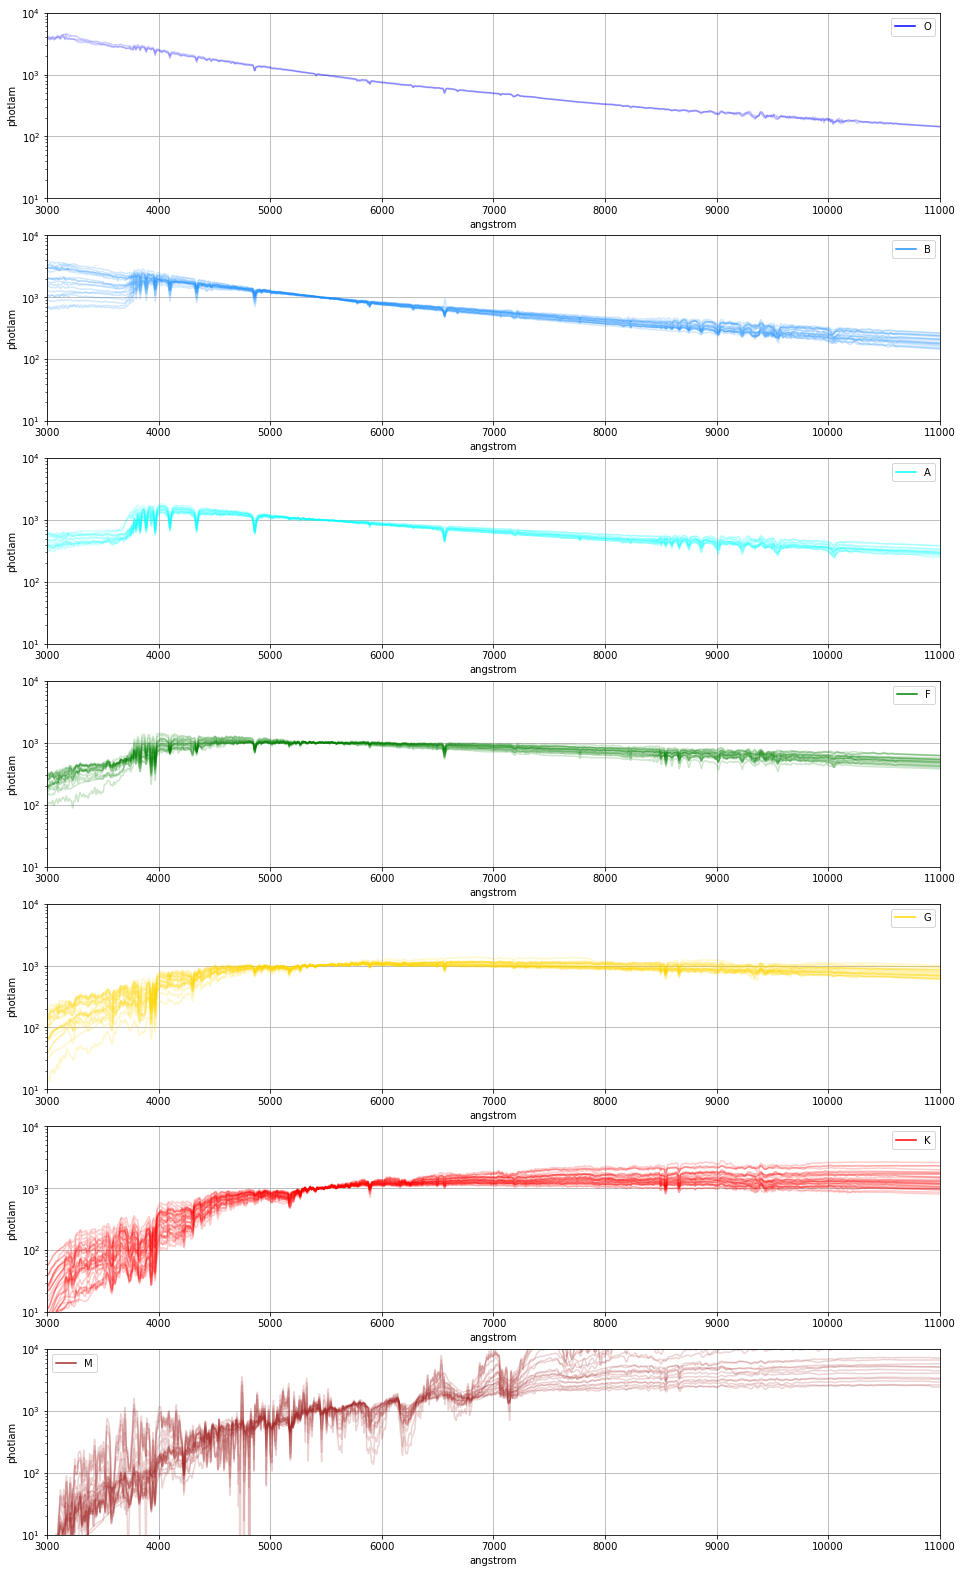

In [14]:
num_rows = len(spectral_types)
fig, axs = plt.subplots(num_rows, 1, figsize=(16,28))

for row,st in enumerate(spectral_types):
    for spec in spec_by_type[st]:
        spec.convert('photlam')
        axs[row].plot(spec.wave,spec.flux,color=type_colors[st],alpha=0.2)
    axs[row].plot([],[],label=st,color=type_colors[st])
    axs[row].grid()
    #axs[row].set_yscale("log")
    axs[row].set_xlabel(spec.waveunits)
    axs[row].set_ylabel(spec.fluxunits)
    axs[row].legend()
    axs[row].set_xlim(3000,11000)
    axs[row].set_ylim(10,10000)
    axs[row].set_yscale("log")
            

# Load LSST's throughput 

https://github.com/lsst/throughputs/tree/main/baseline

In [15]:
throughput_path = 'data/lsst/'
throughput_label = 'hardware_{0}.dat'

In [16]:
filters = ['u','g','r','i','z','Y']
filter_names = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'Y'}
filter_colors = {0:'b',1:'g',2:'r',3:'orange',4:'k',5:'grey'}

Write the throughputs in pysynphot format 

In [17]:
lsst_bp = []
for f in filters:
    throughput_ = np.loadtxt(throughput_path+throughput_label.format(f.lower()))
    wl = throughput_[:,0]*10.
    lsst_bp.append(S.ArrayBandpass(wl, throughput_[:,1] , name=f))


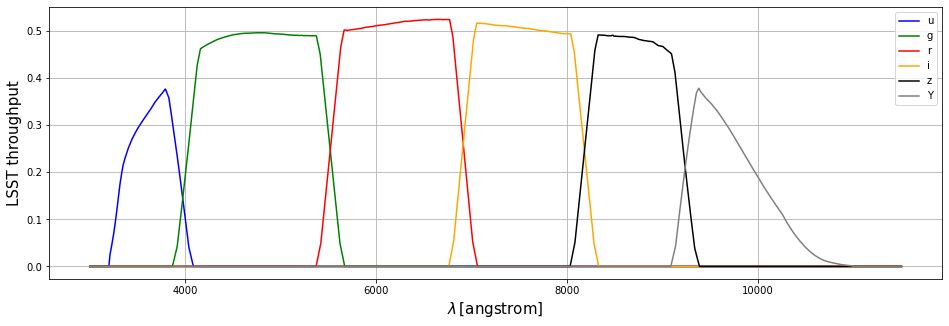

In [18]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for index in range(len(lsst_bp)):
    ax.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
plt.xlabel('$\\lambda \, [$'+str(lsst_bp[0].waveunits)+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

In [19]:
for filter in lsst_bp:
    assert (filter.wave==lsst_bp[0].wave).all()

In [20]:
wl_lsst = lsst_bp[0].wave

# Load simulated transparencies 

Select variable parameter and specify airmass and clouds 

In [21]:
variable_param = 'aerosol'
am0 = 1.2
cloud0 = 0.0
pwv0 = 3.0
aero0 = 0.04

Specify which distribution follows the simulated parameter. Options: 
* linear_distribution-discrete: generated following a linear function and with pre-established step (e.g., PWV = 1.0, 2.0, 3.0, ....) 
* linear_distribution-continuous: generated following a linear function and specifying only the value range and number of simulations (e.g., PWV = 1.0, 1.25, 1.5, ....) 
* uniform_distribution: generated following a uniform random distribution (work in progress) 
* specific_distribution: generated following random distributions specific to each parameter (work in progress) 


In [22]:
param_dist = 'linear_distribution-discrete'

In [23]:
outdir_plots_ = os.path.join('output_plots/',param_dist.split('-')[0])
if os.path.exists(outdir_plots_)==False:
    os.mkdir(outdir_plots_)

outdir_plots = os.path.join('output_plots/',param_dist.replace('-','/'))
if os.path.exists(outdir_plots)==False:
    os.mkdir(outdir_plots)

In [24]:
if variable_param=='airmass' or variable_param=='cloud':
    t_file = 'simulated_transparencies_varying_{0}.fits'.format(variable_param)
    t_file_ref = 'simulated_transparencies_varying_{0}_ref.fits'.format(variable_param)
else:
    t_file = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}.fits'.format(variable_param,am0,cloud0)
    t_file_ref = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}_ref.fits'.format(variable_param,am0,cloud0)

t_path = os.path.join('./simulated_transparencies/',param_dist.replace('-','/'))
t_in = os.path.join(t_path,t_file)
t_in_ref = os.path.join(t_path,t_file_ref)
t = fits.open(t_in)
t_ref = fits.open(t_in_ref)

In [25]:
head = t[0].header
data = t[0].data
print(data.shape)
data_ref = t_ref[0].data
print(data_ref.shape)

(10, 956)
(2, 956)


In [26]:
n_atmp = head['ID_RES']
n_sim = head['NTRANSP']
print(n_atmp, n_sim)

5 9


In [27]:
wl_t = data[0][n_atmp:]*10.

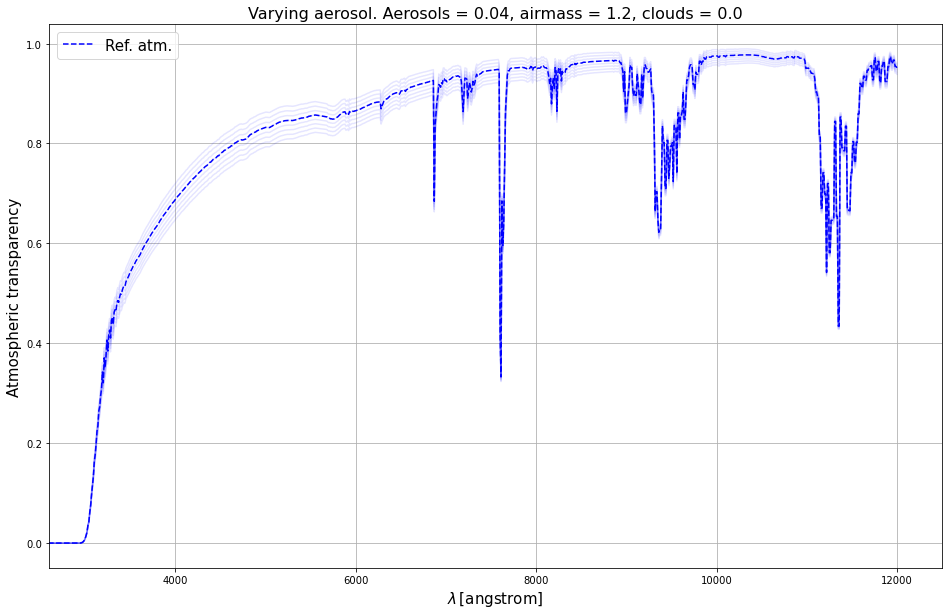

In [28]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for atm_i in range(1,n_sim):
    ax.plot(wl_t,data[atm_i][n_atmp:],color='b',alpha=0.1)
ax.plot(wl_t,data_ref[1][n_atmp:],ls='--',color='b',label='Ref. atm.')
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \,$'+'[angstrom]',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
plt.legend(fontsize=15)
plt.savefig(os.path.join(outdir_plots,'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

# Check range of values of variable parameter 

In [29]:
print(head)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  956                                                  NAXIS2  =                   10                                                  NTRANSP =                    9                                                  ID_AM   =                    4                                                  ID_VAOD =                    1                                                  ID_PWV  =                    0                                                  ID_O3   =                    2                                                  ID_CLD  =                    3                                                  ID_RES  =                    5                                                  END                                     

In [30]:
params_index = {'pwv':0,'aerosol':1,'ozone':2,'cloud':3,'airmass':4}

In [31]:
var_index = params_index[variable_param]

In [32]:
#data[1:,1]
data[1:,var_index]

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

# Select data for variable parameter of these simulations 

In [33]:
atm_vals = data[1:,var_index]

In [34]:
np.save('output_files/atm_vals_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),atm_vals)

# Convert simulated transparencies into pysynphot format 

In [35]:
atm_transp = []
for i in range(1,n_sim+1):
    finterp_i = interp1d(wl_t,data[i][n_atmp:],bounds_error=False,fill_value=0.)
    atm_interp_i = finterp_i(wl_lsst)
    #atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
    atm_i = S.ArrayBandpass(wl_lsst,atm_interp_i, name='Atm. transp. {0}'.format(i))
    atm_transp.append(atm_i)

In [36]:
finterp_ref = interp1d(wl_t,data_ref[1][n_atmp:],bounds_error=False,fill_value=0.)
atm_interp_ref = finterp_ref(wl_lsst)
#atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
atm_transp_ref = S.ArrayBandpass(wl_lsst,atm_interp_ref, name='Atm. transp. {0}'.format(i))

# Compute total bandpass (atmosphere(s) x LSST throughput) 

In [37]:
total_passband = {}
#for bpname in filters:
#    total_passband[bpname] = []

for index,bp in enumerate(lsst_bp):
    total_passband[filters[index]] = []
    for i in range(n_sim):
        total_pass = bp*atm_transp[i]
        total_passband[bp.name].append(total_pass)

In [38]:
total_passband_ref = {}
for index,bp in enumerate(lsst_bp):
    total_pass = bp*atm_transp_ref
    total_passband_ref[bp.name] = total_pass

In [39]:
print(len(total_passband['u']))
print(total_passband['u'][0])

9
(u * Atm. transp. 1)


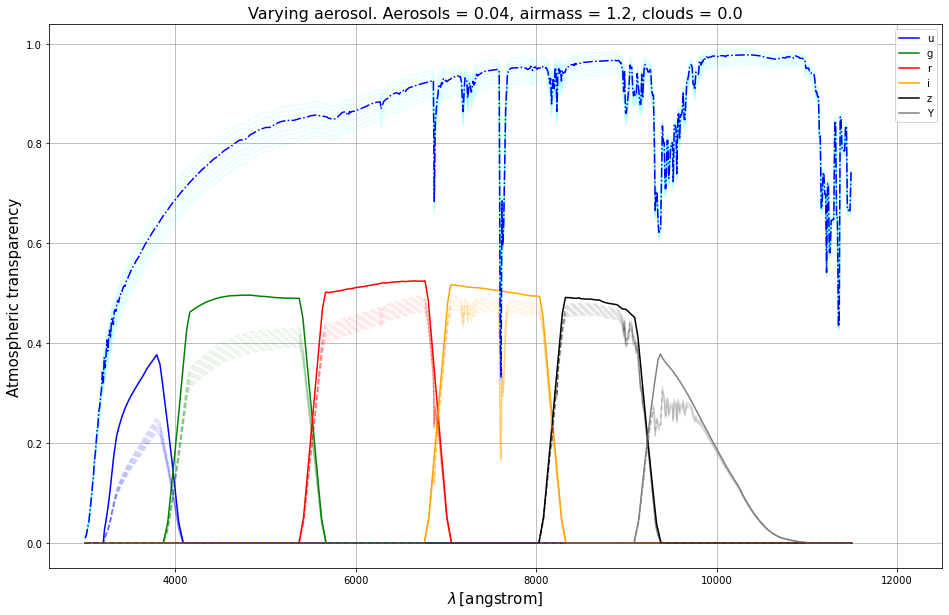

In [40]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for index,bp in enumerate(lsst_bp):
    ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])

for isim in range(n_sim):
    ax.plot(atm_transp[isim].wave,atm_transp[isim].throughput,alpha=0.1,color='cyan')
    for index,bpname in enumerate(filters):
        ax.plot(total_passband[bpname][isim].wave,total_passband[bpname][isim].throughput,ls='--',color=filter_colors[index],alpha=0.1)
ax.plot(atm_transp_ref.wave,atm_transp_ref.throughput,ls='-.',color='b')        
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.legend()
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'total_passbands_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

Plot the atmospheric transparencies corresponding to the minimum and maximum atmospheric parameter that we are varying: 

In [41]:
min_val_ = np.min(atm_vals)
max_val_ = np.max(atm_vals)
print(min_val_,max_val_)

0.01 0.09


In [42]:
min_ind_ = np.where(atm_vals==min_val_)[0][0]
max_ind_ = np.where(atm_vals==max_val_)[0][0]

In [43]:
min_transp = data[1+min_ind_,n_atmp:]
max_transp = data[1+max_ind_,n_atmp:]

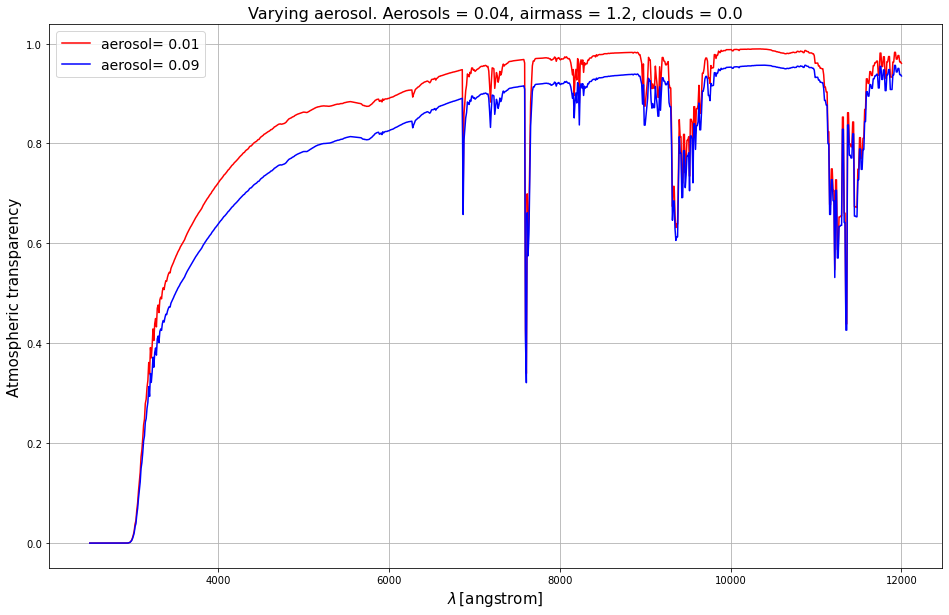

In [44]:
fig=plt.figure(figsize=(16,10))
plt.plot(wl_t,min_transp,color='r',label=variable_param+'= {0:.2f}'.format(min_val_))
plt.plot(wl_t,max_transp,color='b',label=variable_param+'= {0:.2f}'.format(max_val_))
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.grid()
plt.legend(fontsize=14)
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}_min_max_values.png'.format(variable_param,am0,cloud0)))

# Calculate fluxes through total passbands 

Let's start with one spectrum of a type A star as example 

In [45]:
# Example with one spectrum 
test_type = 'A'
test_spec = 0
example_spec = spec_by_type[test_type][test_spec]

In [46]:
# It seems this galaxy is a small enough place to end up choosing again, just by coincidence, Vega as example star 
vega = S.Vega
vega.convert('photlam')

photlam


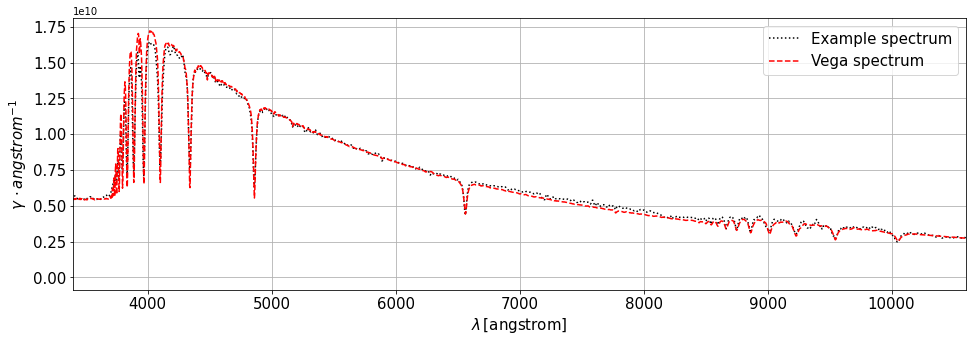

In [47]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0,label='Example spectrum')
plt.plot(vega.wave,vega.flux*Seff*exptime,ls='--',color='r',alpha=1.0,label='Vega spectrum')
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(example_spec.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
print(spec.fluxunits)

Let's make the example spectrum pass through the atmosphere and through the total passband (atm. x throughput) 

In [48]:
obsatm_dict = {}
for isim in range(n_sim):
    obsatm_dict[isim] = []
    obsatm = S.Observation(example_spec,atm_transp[isim],force='taper')
    obsatm_dict[isim] = obsatm

obsatm_ref = S.Observation(example_spec,atm_transp_ref,force='taper')

obstotal_dict = {}
for filter in filters:
    obstotal_dict[filter] = []

#for filter in lsst_bp:
for filter in filters:
    #print(filter.name.upper())
    for i in range(n_sim):
        #total_pass = filter*atm_transp[i]
        #obs = S.Observation(spec,total_pass,force='taper')
        obstotal = S.Observation(example_spec,total_passband[filter][i],force='taper')
        obstotal_dict[filter].append(obstotal)

obstotal_dict_ref = {}
for filter in filters:
    obstotal_dict_ref[filter] = S.Observation(example_spec,total_passband_ref[filter],force='taper')

(Atm. transp. 1) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 3) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 4) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 5) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 6) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 7) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 8) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 9) does not have a defined

u
g
r
i
z
Y
photlam


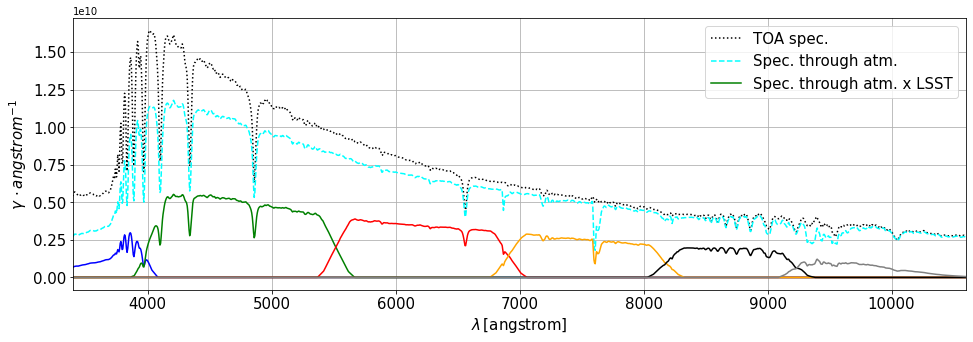

In [49]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

ax.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
ax.plot(obsatm_ref.binwave,obsatm_ref.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)

for index,filter in enumerate(filters):
    print(filter)
    obs = obstotal_dict_ref[filter]
    ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
ax.set_xlim(WLMIN,WLMAX)
ax.set_xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA spec.')
ax.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
ax.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

Now we look at the same information but restricted to the most extreme atmospheric parameter values:

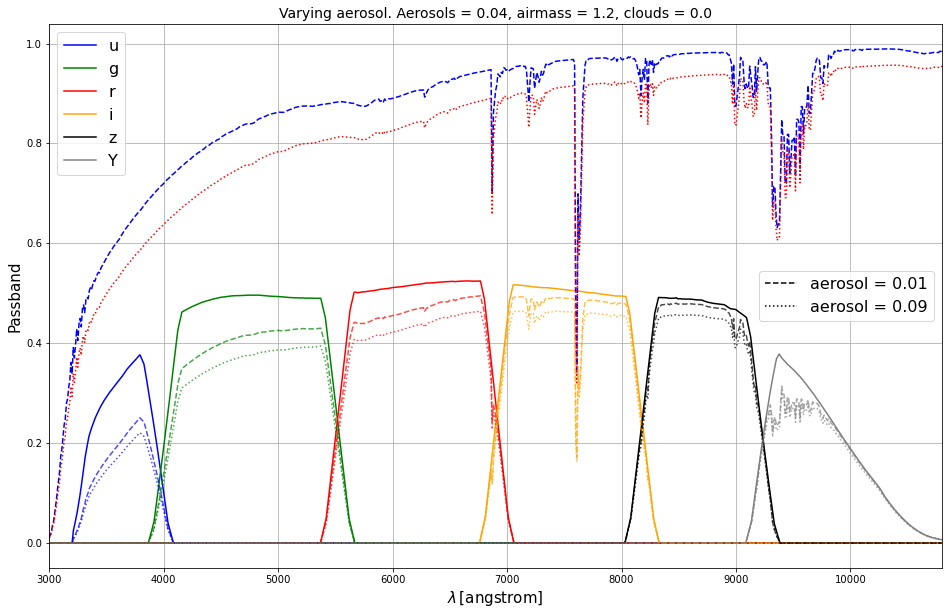

In [50]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
legend_lines1 = []
for index,bp in enumerate(lsst_bp):
    line_, = ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])
    legend_lines1.append(line_)

ax.plot(atm_transp[min_ind_].wave,atm_transp[min_ind_].throughput,ls='--',alpha=1.0,color='b')
ax.plot(atm_transp[max_ind_].wave,atm_transp[max_ind_].throughput,ls=':',alpha=1.0,color='r')

for index,bpname in enumerate(filters):
    ax.plot(total_passband[bpname][min_ind_].wave,total_passband[bpname][min_ind_].throughput,ls='--',color=filter_colors[index],alpha=0.7)
    ax.plot(total_passband[bpname][max_ind_].wave,total_passband[bpname][max_ind_].throughput,ls=':',color=filter_colors[index],alpha=0.7)        
line1, = plt.plot([],[],ls='--',color='k',label='{0} = {1}'.format(variable_param,min_val_))
line2, = plt.plot([],[],ls=':',color='k',label='{0} = {1}'.format(variable_param,max_val_))
legend_lines2 = [line1,line2]
plt.xlim(3000.,10800.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Passband',fontsize=15)
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=14)
legend1 = plt.legend(handles=legend_lines1,fontsize=16,loc="upper left")
plt.gca().add_artist(legend1)
plt.legend(handles=legend_lines2,fontsize=16,loc="center right")
plt.savefig(os.path.join(outdir_plots,'total_passbands_min_max_varying_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0)))

u
g
r
i
z
Y
photlam


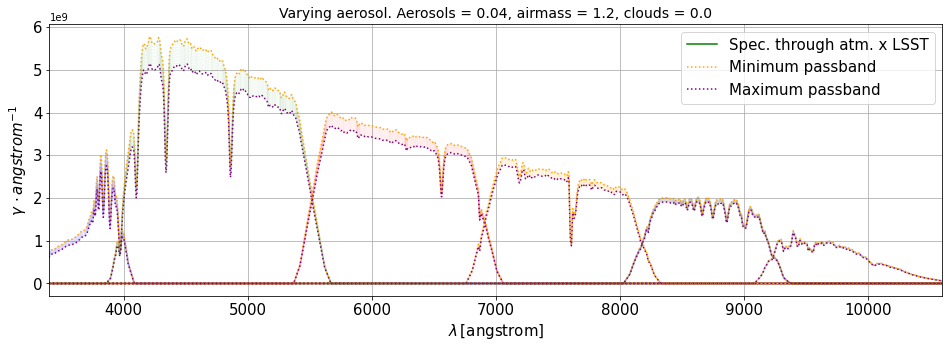

In [51]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

for index,filter in enumerate(filters):
    print(filter)
    for obs in obstotal_dict[filter]:
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.05)
    ax.plot(obstotal_dict[filter][min_ind_].binwave,obstotal_dict[filter][min_ind_].binflux*Seff*exptime,ls=':',color='orange')
    ax.plot(obstotal_dict[filter][max_ind_].binwave,obstotal_dict[filter][max_ind_].binflux*Seff*exptime,ls=':',color='purple')
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')
plt.plot([],[],ls=':',color='orange',label='Minimum passband')
plt.plot([],[],ls=':',color='purple',label='Maximum passband')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=14)
plt.savefig(os.path.join(outdir_plots,'example_spectrum_min_max_total_passband_varying_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0)))
print(spec.fluxunits)

# Calculate magnitudes with our own function 

Physical constants 

In [52]:
c_light = S.units.C #speed of light [Angstrom /s] 
print(c_light)
h_planck = S.units.H #Planck's constant [erg*s] 
print(h_planck)

2.99792458e+18
6.6262e-27


In [53]:
# Reference flux value for an AB source in erg / s / cm2 / Hz 
f_ref = 3.63*10**(-20)

In [54]:
# Pivot wavelength [cm] 
wl_piv = 5.4929*10**(-5)

In [55]:
C = f_ref/(h_planck*wl_piv*10**8.)
print(C)

997.3334660532323


Definition of functions 

In [56]:
# The SED of an AB source (that is, constant flux in frequency units) expressed in photons / s / cm^2 / Angstrom 
def ABnphot(wl):
    #return 997.2*5500./wl
    return C*wl_piv*10**8./wl

We check that this function actually creates a spectrum with the properties of an AB source, that is, a flat spectrum in fnu units (erg/s/cm2/Hz) 

Text(0, 0.5, 'Flux [Jy]')

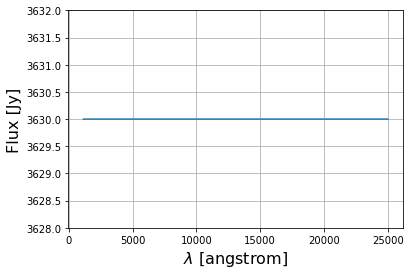

In [57]:
checkab = ABnphot(example_spec.wave)
checkab_ = S.ArraySpectrum(example_spec.wave, checkab, name='Flat AB spectrum')
#plt.plot(checkab_.wave,checkab_.flux)
checkab_.convert('fnu')
plt.plot(checkab_.wave,checkab_.flux*10**23.)
plt.ylim(3.628*10.**3,3.632*10**3.)
plt.grid()
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel('Flux [Jy]',fontsize=16)

Now, we define our function to compute the AB magnitudes: 

$$m_{AB} = -2.5 \log_{10} \frac{\int F_{\nu}^E(\lambda) \cdot S_{eff} \cdot t_{exp} \cdot S_{passband}(\lambda) \frac{d\lambda}{h \lambda}}{\int F_{\nu, AB}^E \cdot S_{eff} \cdot t_{exp} \cdot S_{throughput}(\lambda) \frac{d\lambda}{h \lambda}} = -2.5 \log_{10} \frac{A}{B} \, . $$ 

Now, we want to compute the error for the AB magnitudes. The denominator is constant for a given $S_{throughput}(\lambda)$, so we assume it does not contribute to the error. Then, we can approximate $A$ as 

$$A \approx \sum_i F_{\nu}^E(\lambda_i) \cdot S_{eff} \cdot t_{exp} \cdot S_{passband}(\lambda_i) \frac{\Delta \lambda_i}{h \lambda_i} = \sum_i n_i \cdot S_{passband}(\lambda_i) \cdot \Delta \lambda_i \, , $$ 

where $n_i$ is 

$$n_i = \frac{F_{\nu}^E(\lambda_i) \cdot S_{eff} \cdot t_{exp}}{h \lambda_i} \, ,$$

the number of photo-electrons received within a given bin of wavelength, $\Delta \lambda_i$. Then, we can assume that $n_i$ is a Poisson random variable, so 

$$\sigma^2_{n_i} = n_i . $$ 

Taking this into account, we can write the error of $A$ as 

$$\sigma^2_A = \sum_i \left( \frac{\partial A}{\partial n_i} \right)^2 \sigma^2_{n_i} = \sum_i n_i \cdot \left( S_{passband}(\lambda_i) \cdot \Delta \lambda_i \right)^2 \, , $$ 

Finally, the error on $m_{AB}$ is given by 
$$\sigma^2_{m_{AB}} = \left( \frac{\partial m_{AB}}{\partial A} \right)^2 \sigma^2_A = \left( \frac{-2.5}{A \log 10} \right)^2 \cdot \sum_i n_i \cdot \left( S_{passband}(\lambda_i) \cdot \Delta \lambda_i \right)^2 \, . $$ 


In [58]:
def myAB(spec,passband,filter,return_error=False,renormalize=None):
    f_units = str(spec.fluxunits)
    if f_units!='fnu':
        print('ATTENTION: converting flux units to fnu')
        spec.convert('fnu')
        
    observation = S.Observation(spec,passband,force='taper')
    print('Observation units = ', observation.fluxunits)
    nan_mask = np.isnan(observation.flux)
    
    obs_wave_ = observation.wave[~nan_mask]
    obs_flux_ = observation.flux[~nan_mask]
    wave_min = np.min(observation.wave[~nan_mask])
    wave_max = np.max(observation.wave[~nan_mask])
    
    if renormalize!=None:
        renorm = np.power(10.,-1.*renormalize/2.5)
    else:
        renorm = 1.0
    
    num = np.trapz(obs_flux_*renorm/obs_wave_,x=obs_wave_)*Seff*exptime/h_planck
    
    if return_error:
        finterp_pb = interp1d(passband.wave,passband.throughput,bounds_error=False,fill_value=0.)
        pb_interp = finterp_pb(spec.wave)
        
        delta_lambda = list(np.diff(spec.wave))
        delta_lambda.append(spec.wave[-1]-spec.wave[-2])
        delta_lambda = np.array(delta_lambda)
        assert len(delta_lambda)==len(spec.wave)
        
        assert str(spec.fluxunits)=='fnu'
        n_i = spec.flux*renorm*Seff*exptime/(spec.wave*h_planck)
        print('n_i = ', n_i)
        #print('Number of collected photoelectrons = {0:.2e}'.format(np.sum(n_i*pb_interp)))
        err2_num = np.sum(n_i*(np.array(pb_interp)*delta_lambda)**2.)
    
    spec.convert(f_units)
    
    print('Numerator = {0:.2e}'.format(num))
    if return_error:
        print('Variance of the numerator = {0:.2e}'.format(err2_num))
    
    flatsp_nphot = ABnphot(spec.wave)
    flatsp_ = S.ArraySpectrum(spec.wave, flatsp_nphot, name='Flat AB spectrum')
    
    flatsp_.convert('fnu')
    ab_obs = S.Observation(flatsp_,filter,force='taper')
    print('AB observation units = ', ab_obs.fluxunits)
    
    ab_wave_ = ab_obs.wave[~nan_mask]
    ab_flux_ = ab_obs.flux[~nan_mask]
    
    den = np.trapz(ab_flux_/ab_wave_,x=ab_wave_)*Seff*exptime/h_planck
    
    print('Denominator = {0:.2e}'.format(den))
    mab = -2.5*np.log10(num/den)
    print('AB magnitude = ', mab)
    print('---------')
    
    if return_error:
        err2_mab = (2.5**2./np.log(10.)**2.)*err2_num/num**2.
        err_mab = np.sqrt(err2_mab)
        
        return mab,err_mab
    else:
        return mab

In [59]:
# This function gives the flux of an AB source in photons / s / cm^2 / Angstrom 
flatsp_nphot = ABnphot(example_spec.wave)

In [60]:
#Let's write this in pysynphot format (note that the result will be in photlam units, then we use ABnphot as input)
flatsp = S.ArraySpectrum(example_spec.wave, flatsp_nphot, name='Flat AB spectrum')

Now we check that the AB magnitudes are zero for the flat AB spectrum (they have to be through any filter, by definition) 

In [61]:
for filter in lsst_bp:
    myAB(flatsp,filter,filter)

ATTENTION: converting flux units to fnu
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Observation units =  fnu
Numerator = 3.09e+12
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
AB observation units =  fnu
Denominator = 3.09e+12
AB magnitude =  -0.0
---------
ATTENTION: converting flux units to fnu
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Observation units =  fnu
Numerator = 8.22e+12
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
AB observation units =  fnu
Denominator = 8.22e+12
AB magnitude =  -0.0
---------
ATTENTION: converting flux units to fnu
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Observation units =  fnu
Numerator = 6.16e+12
(r) does not have a defined binset in the w

We check the same for the total passband. Note that, given the definition of AB magnitudes that we have implemented, the denominator only considers the throughput of the telescope, even when the spectra pass through the total passband, since the "reference" we want to compare to is when there is no effect of the atmosphere, but in any case the light passes through the telescope, so we consider the telescope's throughput to be the reference (i.e. as if it had a transmission = 1) with respect to which the flux is attenuated. Therefore, the following AB magnitudes of a flat AB spectrum should be different from (greater than) zero  

In [62]:
for fi,filter in enumerate(filters):
    myAB(flatsp,total_passband[filter][0],lsst_bp[fi])

ATTENTION: converting flux units to fnu
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Observation units =  fnu
Numerator = 1.88e+12
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
AB observation units =  fnu
Denominator = 3.09e+12
AB magnitude =  0.5375197178058375
---------
ATTENTION: converting flux units to fnu
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Observation units =  fnu
Numerator = 6.79e+12
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
AB observation units =  fnu
Denominator = 8.22e+12
AB magnitude =  0.20744411491687778
---------
ATTENTION: converting flux units to fnu
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Obs

Make the flat spectrum pass through the throughputs and total passbands 

In [63]:
flat_dict_t = {}
for fi,filter in enumerate(filters):
    flat_spec_t_ = S.Observation(flatsp,lsst_bp[fi],force='taper')
    flat_dict_t[filter] = flat_spec_t_

flat_dict = {}
for fi,filter in enumerate(filters):
    flat_dict[filter] = []
    for i in range(n_sim):
        flat_spec_ = S.Observation(flatsp,total_passband[filter][i],force='taper')
        flat_dict[filter].append(flat_spec_)

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum wi

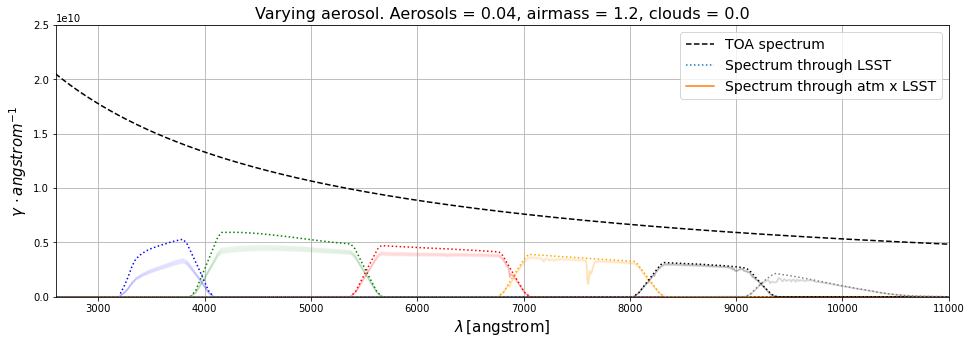

In [64]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
#sed_dict[example_spec].convert('photlam')
if str(flatsp.fluxunits)!='photlam':
    flatsp.convert('photlam')
plt.plot(flatsp.wave,flatsp.flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(flat_dict_t[filter].wave,flat_dict_t[filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        #obs_ = obs_dict[example_spec][filter][i]
        obs_ = flat_dict[filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.04)

plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(2600.,11000.)
plt.ylim(0.,2.5e10)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'flat_spectrum_toa_throughput_total_passband_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

Now, let's see the AB magnitudes of the example spectrum with myAB function. To better understand it, we can compare the AB spectrum and the example spectrum (Vega) flux amplitudes in each range of wavelengths (see plot below) 

photlam


Text(0, 0.5, '$\\gamma / angstrom$')

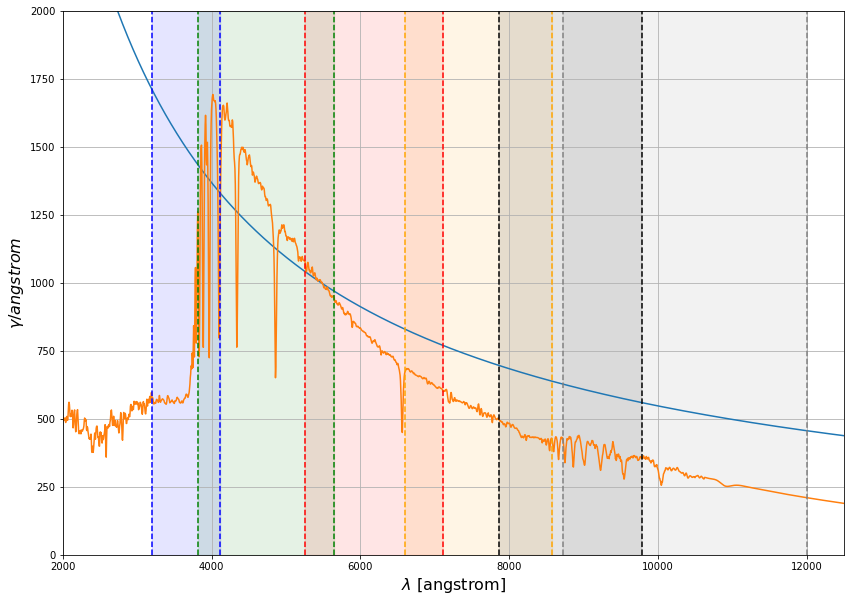

In [65]:
print(flatsp.fluxunits)
flatsp.convert('photlam')
example_spec.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(example_spec.wave,example_spec.flux)

# Approximate integration limits of each total passband. Note that there is some overlap 
plt.axvline(x=3200,ls='--',color=filter_colors[0])
plt.axvline(x=4120,ls='--',color=filter_colors[0])
plt.fill_between(np.arange(3200,4120),np.ones(len(np.arange(3200,4120)))*2000.,color=filter_colors[0],alpha=0.1)

plt.axvline(x=3820,ls='--',color=filter_colors[1])
plt.axvline(x=5650,ls='--',color=filter_colors[1])
plt.fill_between(np.arange(3820,5650),np.ones(len(np.arange(3820,5650)))*2000.,color=filter_colors[1],alpha=0.1)

plt.axvline(x=5250,ls='--',color=filter_colors[2])
plt.axvline(x=7110,ls='--',color=filter_colors[2])
plt.fill_between(np.arange(5250,7110),np.ones(len(np.arange(5250,7110)))*2000.,color=filter_colors[2],alpha=0.1)

plt.axvline(x=6600,ls='--',color=filter_colors[3])
plt.axvline(x=8580,ls='--',color=filter_colors[3])
plt.fill_between(np.arange(6600,8580),np.ones(len(np.arange(6600,8580)))*2000.,color=filter_colors[3],alpha=0.1)

plt.axvline(x=7860,ls='--',color=filter_colors[4])
plt.axvline(x=9780,ls='--',color=filter_colors[4])
plt.fill_between(np.arange(7860,9780),np.ones(len(np.arange(7860,9780)))*2000.,color=filter_colors[4],alpha=0.1)

plt.axvline(x=8720,ls='--',color=filter_colors[5])
plt.axvline(x=12000,ls='--',color=filter_colors[5])
plt.fill_between(np.arange(8720,12000),np.ones(len(np.arange(8720,12000)))*2000.,color=filter_colors[5],alpha=0.1)

plt.xlim(2000.,12500.)
plt.ylim(0.,2000.)
plt.grid()
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel(r'$\gamma / angstrom$',fontsize=16)

In [66]:
for filter in lsst_bp:
    myAB(example_spec,filter,filter)

ATTENTION: converting flux units to fnu
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Observation units =  fnu
Numerator = 1.59e+12
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
AB observation units =  fnu
Denominator = 3.09e+12
AB magnitude =  0.7222408197036627
---------
ATTENTION: converting flux units to fnu
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Observation units =  fnu
Numerator = 8.95e+12
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
AB observation units =  fnu
Denominator = 8.22e+12
AB magnitude =  -0.09224087927554477
---------
ATTENTION: converting flux units to fnu
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Observation units =  fnu
Numerator = 5.43e+12
(r) does not 

In [67]:
for fi,filter in enumerate(filters):
    myAB(example_spec,total_passband[filter][0],lsst_bp[fi])

ATTENTION: converting flux units to fnu
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Observation units =  fnu
Numerator = 1.01e+12
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
AB observation units =  fnu
Denominator = 3.09e+12
AB magnitude =  1.2175744456051412
---------
ATTENTION: converting flux units to fnu
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Observation units =  fnu
Numerator = 7.38e+12
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
AB observation units =  fnu
Denominator = 8.22e+12
AB magnitude =  0.1171906588860904
---------
ATTENTION: converting flux units to fnu
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Obse

u
g
r
i
z
Y
photlam


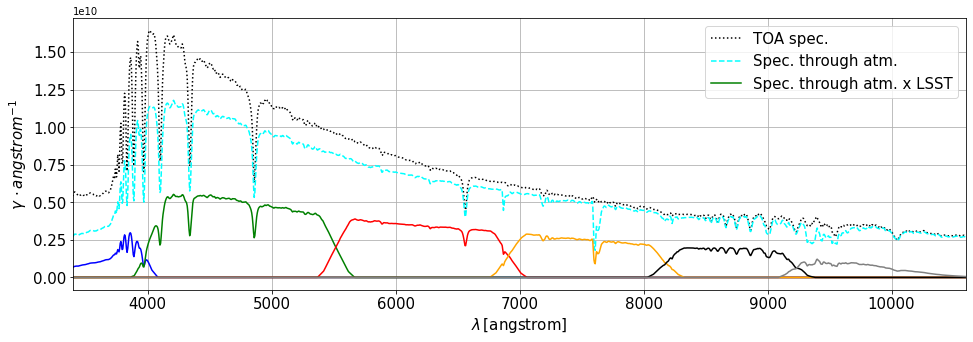

In [68]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

ax.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
ax.plot(obsatm_ref.binwave,obsatm_ref.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)

for index,filter in enumerate(filters):
    print(filter)
    obs = obstotal_dict_ref[filter]
    ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)

ax.set_xlim(WLMIN,WLMAX)
ax.set_xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA spec.')
ax.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
ax.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

In [69]:
mag_dict_std= {}
mag_dict_min = {}
mag_dict_max = {}

for index,filter in enumerate(filters):
    #mag_dict_[filter] = obs_spec_[filter].effstim("abmag")
    mag_ab_,mag_ab_err_ = myAB(example_spec,total_passband_ref[filter],lsst_bp[index],return_error=True)
    mag_dict_std[filters[index]] = mag_ab_
    print(mag_ab_err_)
    mag_ab_,mag_ab_err_ = myAB(example_spec,total_passband[filter][min_ind_],lsst_bp[index],return_error=True)
    mag_dict_min[filters[index]] = mag_ab_
    mag_ab_,mag_ab_err_ = myAB(example_spec,total_passband[filter][max_ind_],lsst_bp[index],return_error=True)
    mag_dict_max[filters[index]] = mag_ab_
    print('#############')
    

ATTENTION: converting flux units to fnu
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Observation units =  fnu
n_i =  [2.72591039e+08 3.79702902e+08 2.60596515e+08 ... 2.96819390e+08
 2.97517746e+08 2.23091475e+08]
Numerator = 9.59e+11
Variance of the numerator = 8.36e+11
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
AB observation units =  fnu
Denominator = 3.09e+12
AB magnitude =  1.27004900323179
---------
1.0355471911197254e-06
ATTENTION: converting flux units to fnu
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Observation units =  fnu
n_i =  [2.72591039e+08 3.79702902e+08 2.60596515e+08 ... 2.96819390e+08
 2.97517746e+08 2.23091475e+08]
Numerator = 1.01e+12
Variance of the numerator = 9.21e+11
(u) does not have a defined binset in the wavecat table. The waveset o

In [70]:
mag_dict_std

{'u': 1.27004900323179,
 'g': 0.1589965313615171,
 'r': 0.2768480595602084,
 'i': 0.419163175664647,
 'z': 0.5293355136489002,
 'Y': 0.6779896449642355}

In [71]:
mag_dict_min, mag_dict_max

({'u': 1.2175744456051412,
  'g': 0.1171906588860904,
  'r': 0.2473570014136402,
  'i': 0.39649278687631584,
  'z': 0.5106778041764196,
  'Y': 0.662815875565516},
 {'u': 1.3566673194776182,
  'g': 0.2284646498257505,
  'r': 0.3265926718132814,
  'i': 0.4579931235183937,
  'z': 0.5617457251798059,
  'Y': 0.7048244897379964})

u
g
r
i
z
Y
photlam


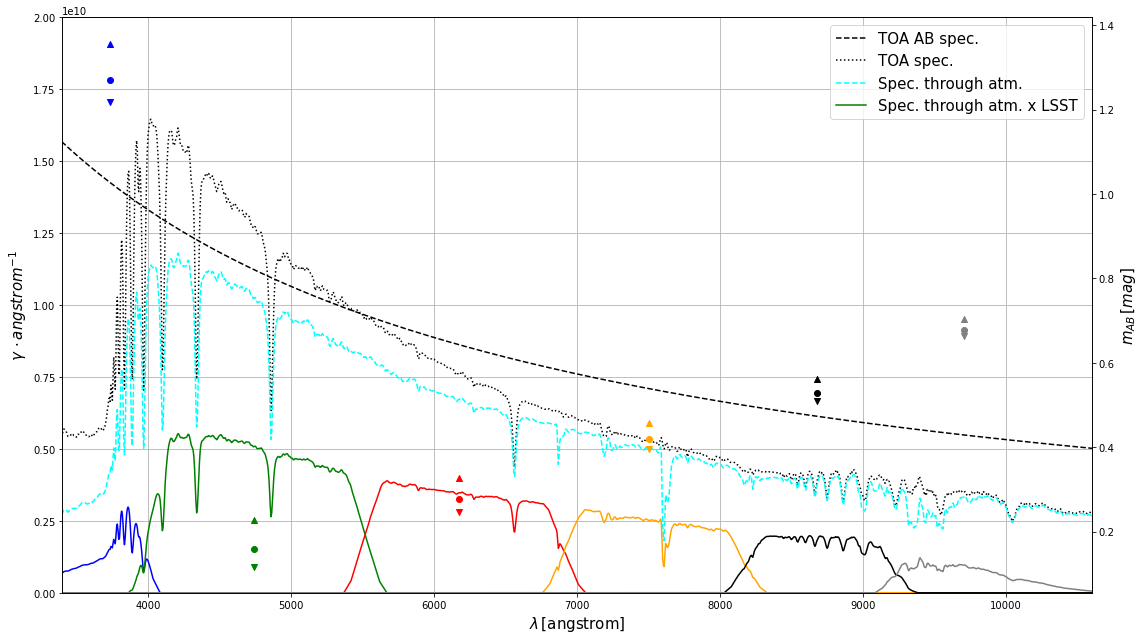

In [72]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
ax1.plot(flatsp.wave,flatsp.flux*Seff*exptime,ls='--',color='k',label='TOA AB spec.')

ax1.plot(obsatm_ref.binwave,obsatm_ref.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)
ax2 = ax1.twinx()

eff_lambda = {}
for index,filter in enumerate(filters):
    print(filter)
    obs = obstotal_dict_ref[filter]
    #for obs in obstotal_dict[filter]:
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
    
    #obs_ref_ = obstotal = S.Observation(example_spec,total_passband_ref[filter],force='taper')
    eff_l_ = obs.efflam()
    eff_lambda[filter] = eff_l_
    

ax1.set_xlim(WLMIN,WLMAX)
ax1.set_ylim(-1.,2e10)
ax1.set_xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
ax1.grid()
ax1.plot([],[],ls=':',color='k',label='TOA spec.')
ax1.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
ax1.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')

for index,band_ in enumerate(filters):
    ax2.scatter(eff_lambda[band_],mag_dict_std[band_],marker='o',color=filter_colors[index])
    ax2.scatter(eff_lambda[band_],mag_dict_min[band_],marker='v',color=filter_colors[index])
    ax2.scatter(eff_lambda[band_],mag_dict_max[band_],marker='^',color=filter_colors[index])

ax2.set_ylabel(r'$m_{AB} \, [mag]$',fontsize=15)
ax1.legend(fontsize=15)
plt.tight_layout()
print(spec.fluxunits)

In [73]:
uu = str(example_spec.fluxunits)
example_spec.convert('fnu')
print(example_spec.fluxunits)
observation = S.Observation(example_spec,total_passband_ref['g'],force='taper')
print(observation.fluxunits)
example_spec.convert(uu)
print(example_spec.fluxunits)

fnu
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
fnu
photlam


In [74]:
def myPhi(spec,passband,return_error=False,renormalize=None,verbose=True):
    f_units = str(spec.fluxunits)
    if f_units!='fnu':
        if verbose:
            print('ATTENTION: converting flux units to fnu')
        spec.convert('fnu')
        
    observation = S.Observation(spec,passband,force='taper')
    #print('Observation units = ', observation.fluxunits)
    nan_mask = np.isnan(observation.flux)
    
    obs_wave_ = observation.wave[~nan_mask]
    obs_flux_ = observation.flux[~nan_mask]
    wave_min = np.min(observation.wave[~nan_mask])
    wave_max = np.max(observation.wave[~nan_mask])
    
    if renormalize!=None:
        renorm = np.power(10.,-1.*renormalize/2.5)
    else:
        renorm = 1.0
    
    num = np.trapz(obs_flux_*renorm/obs_wave_,x=obs_wave_)*Seff*exptime/h_planck
    
    if return_error:
        finterp_pb = interp1d(passband.wave,passband.throughput,bounds_error=False,fill_value=0.)
        pb_interp = finterp_pb(spec.wave)
        
        delta_lambda = list(np.diff(spec.wave))
        delta_lambda.append(spec.wave[-1]-spec.wave[-2])
        delta_lambda = np.array(delta_lambda)
        assert len(delta_lambda)==len(spec.wave)
        
        assert str(spec.fluxunits)=='fnu'
        n_i = spec.flux*renorm*Seff*exptime/(spec.wave*h_planck)
        #print('n_i = ', n_i)
        #print('Number of collected photoelectrons = {0:.2e}'.format(np.sum(n_i*pb_interp)))
        err2_num = np.sum(n_i*(np.array(pb_interp)*delta_lambda)**2.)
        err_num = np.sqrt(err2_num)
    
    spec.convert(f_units)
    
    #print('Numerator = {0:.2e}'.format(num))
    if return_error and verbose:
        print('Variance of the numerator = {0:.2e}'.format(err2_num))
    
    if return_error:
        err2_mab = (2.5**2./np.log(10.)**2.)*err2_num/num**2.
        err_mab = np.sqrt(err2_mab)
        
        return num,err_num
    else:
        return num

In [75]:
phi_dict_std = {}
phi_dict_std_err = {}
phi_dict_min = {}
phi_dict_max = {}

for filter in filters:
    num_,num_err_ = myPhi(example_spec,total_passband_ref[filter],return_error=True)
    phi_dict_std[filter] = num_
    phi_dict_std_err[filter] = num_err_
    print(num_err_)
    num_ = myPhi(example_spec,total_passband[filter][min_ind_],return_error=False)
    phi_dict_min[filter] = num_
    num_ = myPhi(example_spec,total_passband[filter][max_ind_],return_error=False)
    phi_dict_max[filter] = num_
    print('#############')
    

ATTENTION: converting flux units to fnu
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Variance of the numerator = 8.36e+11
914448.5885501296
ATTENTION: converting flux units to fnu
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
ATTENTION: converting flux units to fnu
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
#############
ATTENTION: converting flux units to fnu
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Variance of the numerator = 1.31e+13
3620105.4156496255
ATTENTION: converting flux units to fnu
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
ATTENTION: converting flux units to fnu
((g *

u
g
r
i
z
Y
photlam


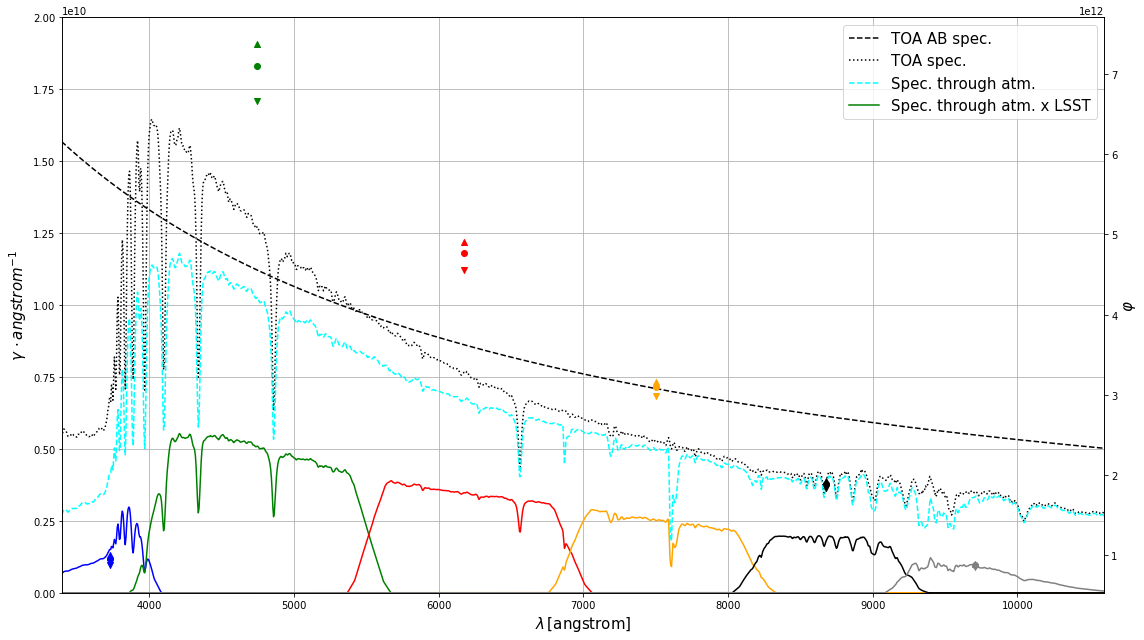

In [76]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
ax1.plot(flatsp.wave,flatsp.flux*Seff*exptime,ls='--',color='k',label='TOA AB spec.')

ax1.plot(obsatm_ref.binwave,obsatm_ref.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)
ax2 = ax1.twinx()

eff_lambda = {}
for index,filter in enumerate(filters):
    print(filter)
    obs = obstotal_dict_ref[filter]
    #for obs in obstotal_dict[filter]:
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
    
    #obs_ref_ = obstotal = S.Observation(example_spec,total_passband_ref[filter],force='taper')
    eff_l_ = obs.efflam()
    eff_lambda[filter] = eff_l_
    

ax1.set_xlim(WLMIN,WLMAX)
ax1.set_ylim(-1.,2e10)
ax1.set_xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
ax1.grid()
ax1.plot([],[],ls=':',color='k',label='TOA spec.')
ax1.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
ax1.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda[filter],phi_dict_std[filter],marker='o',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter],phi_dict_min[filter],marker='^',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter],phi_dict_max[filter],marker='v',color=filter_colors[index])

ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=15)
plt.tight_layout()
print(spec.fluxunits)

### We store the observed integrated flux, $\vec{\varphi}_i(t)$ 

We store it for 3 example cases: 
- Minimum total passband 
- Maximum total passband 
- Standard atmosphere 

In [77]:
wl_eff = []
phi_std = []
phi_min = []
phi_max = []
for filter in filters:
    print(filter)
    wl_eff.append(eff_lambda[filter])
    phi_std.append(phi_dict_std[filter])
    phi_min.append(phi_dict_min[filter])
    phi_max.append(phi_dict_max[filter])
wl_eff = np.array(wl_eff)
phi_std = np.array(phi_std)
phi_min = np.array(phi_min)
phi_max = np.array(phi_max)

u
g
r
i
z
Y


# Black body spectrum 

<img align="center" src = blackbody.gif width=350 style="padding: 10px"> 

http://burro.cwru.edu/academics/Astr221/Light/blackbody.gif

The amount of energy emited by a black body at given temperature, $T$, per unit time, area, solid angle and wavelength is given by the Planck's law: 

$$B(\lambda,T) = \frac{2hc^2}{\lambda^5}\frac{1}{e^{hc/\lambda k T}-1} \, . $$

Since the objects that we work with as black bodies are far, far away, we can consider them as puntual, so we assume that the integrating solid angle is $d\Omega$. Therefore, we consider the units of this spectrum to be 

$$\newcommand{\AA}{\mathcal{\unicode{x212B}}}$$
$$B(\lambda,T) = \left[ \frac{erg}{s \cdot cm^2 \cdot \AA } \right]$$


In [78]:
#Boltzmann's constant [erg / K]
k_boltzmann = S.planck.K*1e7
print(k_boltzmann,c_light,h_planck)

1.38062e-16 2.99792458e+18 6.6262e-27


In [79]:
def black_body(l,T):
    A = l/(h_planck*c_light)
    numerator = 2.*h_planck*c_light**2./l**5.
    denominator = np.exp(h_planck*c_light/(l*k_boltzmann*T))-1.
    B = A*numerator/denominator
    #bb_spec_ = S.ArraySpectrum(l,B,name='Black body spectrum, T={0}K'.format(T))
    #return bb_spec_
    #return l,B
    return B

In [80]:
Ttest = 5000
bb0_ = black_body(wl,Ttest)
#l0,bb0_test = black_body(np.arange(10,30000,1),5000)

In [81]:
#bb0.fluxunits, example_spec.fluxunits

Text(0, 0.5, '$B(\\lambda,T=$5000K)')

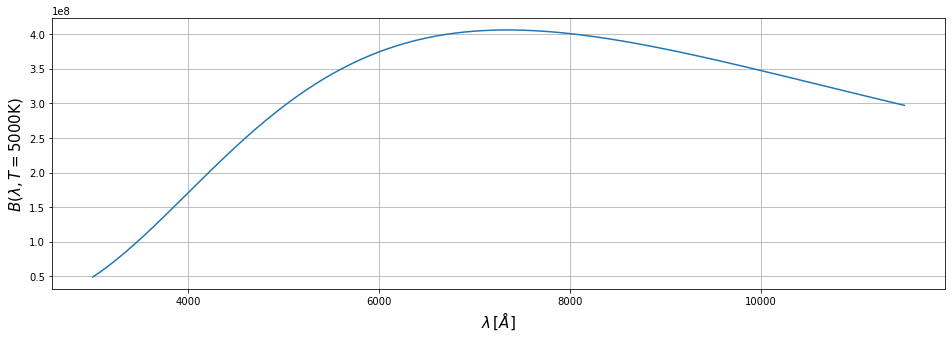

In [82]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
ax.plot(wl,bb0_*Seff*exptime)
#ax.set_yscale("log")
ax.grid()
ax.set_xlabel(r'$\lambda  \,[\AA]$',fontsize=15)
ax.set_ylabel(r'$B(\lambda,T=$'+'{0}K)'.format(Ttest),fontsize=15)

### We test the generated black body spectrum by passing it through the standard atmosphere and the total passband 

In [83]:

bb0 = S.ArraySpectrum(wl,bb0_,name='Black body spectrum, T={0}K'.format(Ttest))

bb0_atm_std = S.Observation(bb0,atm_transp_ref,force='taper')

bb0_total_dict = {}
for filter in filters:
    #print(filter.name.upper())
    #total_pass = filter*atm_transp[i]
    #obs = S.Observation(spec,total_pass,force='taper')
    bbtotal = S.Observation(bb0,total_passband_ref[filter],force='taper')
    bb0_total_dict[filter] = bbtotal

(Atm. transp. 9) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


u
g
r
i
z
Y
photlam


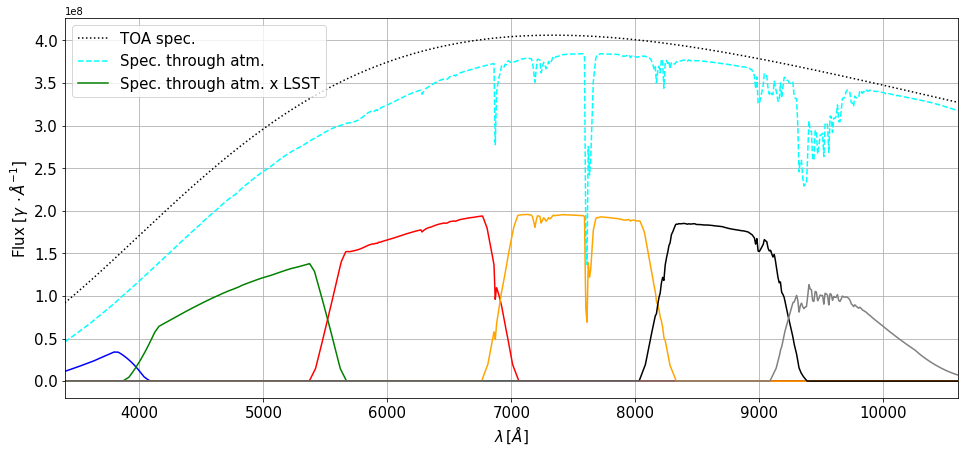

In [84]:
fig=plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)

ax.plot(bb0.wave,bb0.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
ax.plot(bb0_atm_std.binwave,bb0_atm_std.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)

for index,filter in enumerate(filters):
    print(filter)
    obs = bb0_total_dict[filter]
    #for obs in obstotal_dict[filter]:
    ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)

ax.set_xlim(WLMIN,WLMAX)
#ax.set_ylim(0.,0.5e13)
if str(obs.waveunits)=='angstrom':
    xlabel_ = r'$\lambda \, [\AA]$'
    ylabel_ = r'Flux $[\gamma \, \cdot \AA^{-1}]$'
else:
    xlabel_ = r'$\lambda \, [$'+str(obs.waveunits)+']'
    ylabel_ = r'Flux $[\gamma \, \cdot $'+str(obs.waveunits)+r'$^{-1}]$'
ax.set_xlabel(xlabel_,fontsize=15)
ax.set_ylabel(ylabel_,fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA spec.')
ax.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
ax.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

In [85]:
Phi_dict_bb_test_std = {}
Phi_dict_bb_test_std_err = {}
for filter in filters:
    #mag_dict_[filter] = obs_spec_[filter].effstim("abmag")
    num_,num_err_ = myPhi(bb0,total_passband_ref[filter],return_error=True)
    Phi_dict_bb_test_std[filter] = num_
    Phi_dict_bb_test_std_err[filter] = num_err_
    #print(num_err_)
    #print('#############')
    

ATTENTION: converting flux units to fnu
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Variance of the numerator = 2.79e+09
ATTENTION: converting flux units to fnu
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Variance of the numerator = 5.92e+10
ATTENTION: converting flux units to fnu
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Variance of the numerator = 1.04e+11
ATTENTION: converting flux units to fnu
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Variance of the numerator = 1.04e+11
ATTENTION: converting flux units to fnu
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Variance of the numera

u
g
r
i
z
Y
photlam


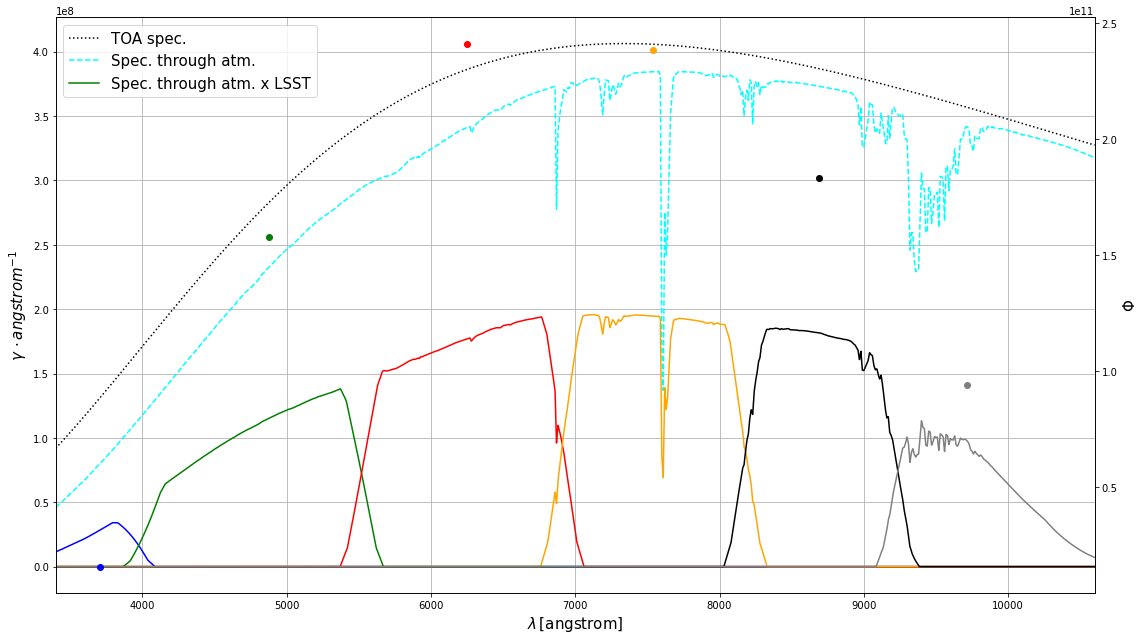

In [86]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(bb0.wave,bb0.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
#ax1.plot(flatsp.wave,flatsp.flux*Seff*exptime,ls='--',color='k',label='TOA AB spec.')

ax1.plot(bb0_atm_std.binwave,bb0_atm_std.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)
ax2 = ax1.twinx()

eff_lambda_bb0 = {}
for index,filter in enumerate(filters):
    print(filter)
    obs = bb0_total_dict[filter]
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
    
    #obs_ref_ = obstotal = S.Observation(example_spec,total_passband_ref[filter],force='taper')
    eff_l_ = obs.efflam()
    eff_lambda_bb0[filter] = eff_l_
    
ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_ylim(0.,0.5e13)
ax1.set_xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
ax1.grid()
ax1.plot([],[],ls=':',color='k',label='TOA spec.')
ax1.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
ax1.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')

for index,band_ in enumerate(filters):
    ax2.scatter(eff_lambda_bb0[band_],Phi_dict_bb_test_std[band_],marker='o',color=filter_colors[index])

ax2.set_ylabel(r'$\Phi$',fontsize=15)
ax1.legend(fontsize=15)
plt.tight_layout()
print(spec.fluxunits)

### Now we define the best fit black body spectrum by fitting it to the data 

In [87]:
def calc_chi2(data,model,error=None):
    
    assert len(data)==len(model)
    
    chi2 = 0.
    for i in range(len(data)):
        if error is not None:
            chi2 = chi2+np.sum((data[i]-model[i])**2./error[i]**2.)
        else:
            chi2 = chi2+np.sum((data[i]-model[i])**2.)
    return chi2
        

In [88]:
def best_bb(l,phi_ugrizy_mes,passband,phi_err=None,T=[2000,30000],Tstep=100,verbose=False):
    
    data_vec = []
    for filter in filters:
        data_vec.append(phi_ugrizy_mes[filter])
    data_vec = np.array(data_vec)
    
    if phi_err is not None:
        data_vec_err = []
        for filter in filters:
            data_vec_err.append(phi_err[filter])
        data_vec_err = np.array(data_vec_err)
    else:
        data_vec_err = None
    
    temps = np.arange(T[0],T[-1],Tstep)
    chi2s = []
    for temp_ in temps:
        bb_ = black_body(l,temp_)
        bb_spec_ = S.ArraySpectrum(l,bb_)
        model_vec_ = []
        for filter in filters:
            num_ = myPhi(bb_spec_,passband[filter],return_error=False,verbose=verbose)
            model_vec_.append(num_)
        model_vec_ = np.array(model_vec_)
        
        chi2_ = calc_chi2(data_vec,model_vec_,error=data_vec_err)
        
        chi2s.append(chi2_)
        
    chi2s = np.array(chi2s)
    
    return temps, chi2s
    

### First we try with the manually generated black body 

In [89]:
#Temps, chi2s = best_bb(bb0_test.wave,phi_dict,total_passband_ref,Phi_err=phi_dict_err,T=[3000,6000],Tstep=100)
Temps, chi2s = best_bb(bb0.wave,Phi_dict_bb_test_std,total_passband_ref,phi_err=None,T=[3000,6000],Tstep=100)

((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

In [90]:
chi2s

array([1.59094496e+23, 1.53907684e+23, 1.48030774e+23, 1.41451895e+23,
       1.34172433e+23, 1.26208769e+23, 1.17593971e+23, 1.08379462e+23,
       9.86366270e+22, 8.84583783e+22, 7.79606537e+22, 6.72838490e+22,
       5.65941745e+22, 4.60849303e+22, 3.59776920e+22, 2.65234005e+22,
       1.80033507e+22, 1.07300716e+22, 5.04809604e+21, 1.33461258e+21,
       0.00000000e+00, 1.48824036e+21, 6.27721063e+21, 1.48788531e+22,
       2.78392256e+22, 4.57384340e+22, 6.91904503e+22, 9.88428196e+22,
       1.35376262e+23, 1.79504172e+23])

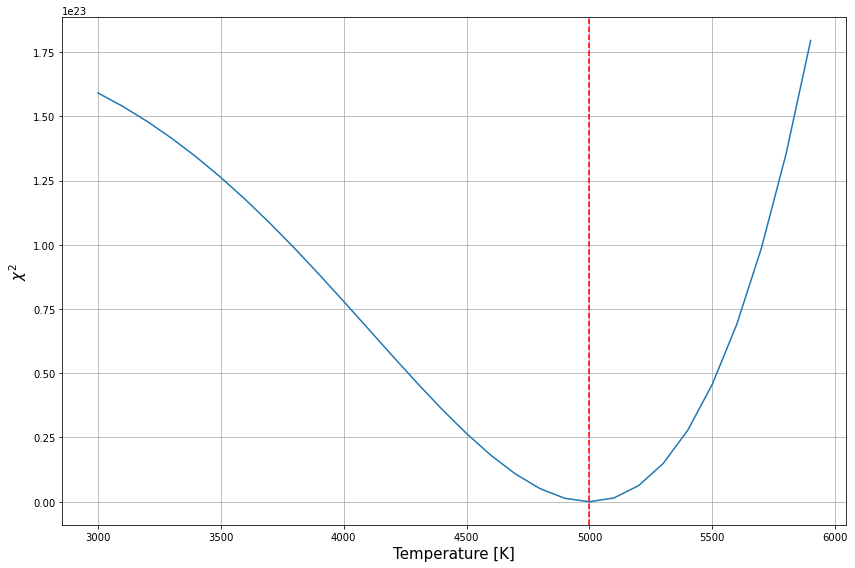

In [91]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ax.plot(Temps,chi2s)
ax.axvline(x=Temps[chi2s==np.min(chi2s)],ls='--',color='r')
ax.grid()
ax.set_xlabel('Temperature [K]',fontsize=15)
ax.set_ylabel(r'$\chi^2$',fontsize=15)
plt.tight_layout()

### Now, we compute the best fit black body spectra for the real spectrum passing through 

- the standard atmosphere; 
- the minimum value atmosphere; 
- the maximum value atmosphere. 


In [92]:
T_interval = [10000,14000]
Tstep = 50

In [93]:
Temps_std, chi2s_std = best_bb(example_spec.wave,phi_dict_std,total_passband_ref,phi_err=None,T=T_interval,Tstep=Tstep,verbose=False)
print('--------------')
Temps_min, chi2s_min = best_bb(example_spec.wave,phi_dict_min,total_passband_ref,phi_err=None,T=T_interval,Tstep=Tstep,verbose=False)
print('--------------')
Temps_max, chi2s_max = best_bb(example_spec.wave,phi_dict_max,total_passband_ref,phi_err=None,T=T_interval,Tstep=Tstep,verbose=False)
print('--------------')

((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

In [94]:
chi2s_std

array([2.05654683e+25, 1.99442469e+25, 1.93295198e+25, 1.87214879e+25,
       1.81203508e+25, 1.75263080e+25, 1.69395581e+25, 1.63602985e+25,
       1.57887266e+25, 1.52250385e+25, 1.46694303e+25, 1.41220952e+25,
       1.35832280e+25, 1.30530213e+25, 1.25316669e+25, 1.20193571e+25,
       1.15162805e+25, 1.10226279e+25, 1.05385871e+25, 1.00643461e+25,
       9.60009105e+24, 9.14600808e+24, 8.70228200e+24, 8.26909579e+24,
       7.84663360e+24, 7.43507663e+24, 7.03460607e+24, 6.64540146e+24,
       6.26764237e+24, 5.90150638e+24, 5.54717070e+24, 5.20481131e+24,
       4.87460346e+24, 4.55672052e+24, 4.25133586e+24, 3.95862219e+24,
       3.67874964e+24, 3.41188816e+24, 3.15820699e+24, 2.91787401e+24,
       2.69105638e+24, 2.47791953e+24, 2.27862903e+24, 2.09334815e+24,
       1.92224014e+24, 1.76546625e+24, 1.62318809e+24, 1.49556515e+24,
       1.38275592e+24, 1.28491839e+24, 1.20220923e+24, 1.13478432e+24,
       1.08279769e+24, 1.04640471e+24, 1.02575641e+24, 1.02100513e+24,
      

In [95]:
Tfit_std = Temps_std[chi2s_std==np.min(chi2s_std)]
Tfit_min = Temps_min[chi2s_min==np.min(chi2s_min)]
Tfit_max = Temps_max[chi2s_max==np.min(chi2s_max)]
print(Tfit_std,Tfit_min,Tfit_max)

[12750] [12900] [12450]


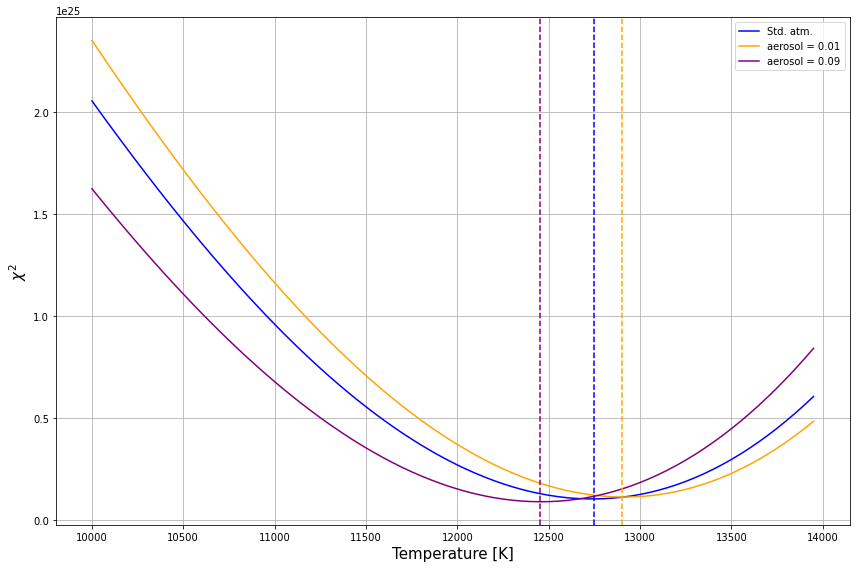

In [96]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ax.plot(Temps_std,chi2s_std,color='b',label='Std. atm.')
ax.plot(Temps_min,chi2s_min,color='orange',label='{0} = {1}'.format(variable_param,min_val_))
ax.plot(Temps_max,chi2s_max,color='purple',label='{0} = {1}'.format(variable_param,max_val_))
ax.axvline(x=Tfit_std,ls='--',color='b')
ax.axvline(x=Tfit_min,ls='--',color='orange')
ax.axvline(x=Tfit_max,ls='--',color='purple')
ax.grid()
ax.set_xlabel('Temperature [K]',fontsize=15)
ax.set_ylabel(r'$\chi^2$',fontsize=15)
ax.legend(loc="best")
plt.tight_layout()

In [97]:
bb_spec_std = black_body(wl,Tfit_std)
bb_spec_min = black_body(wl,Tfit_min)
bb_spec_max = black_body(wl,Tfit_max)


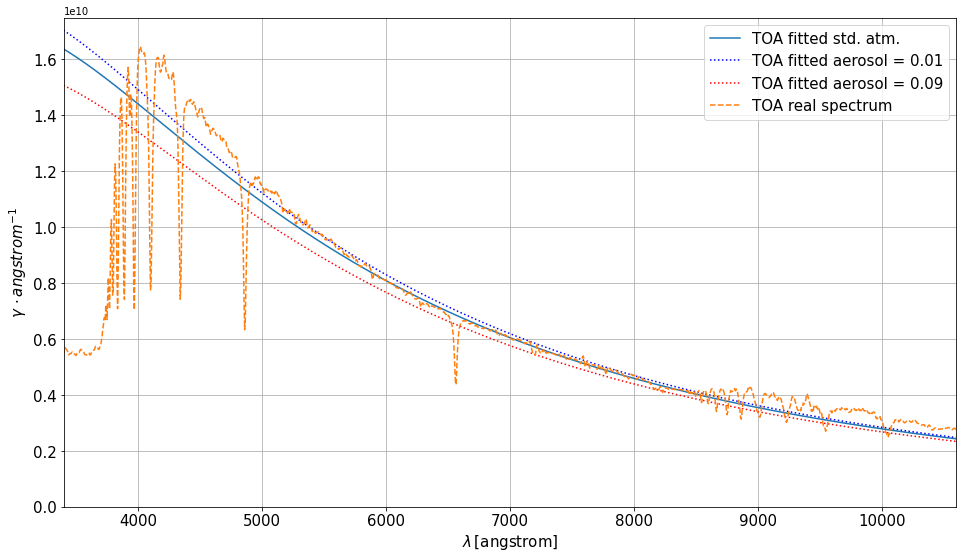

In [98]:
fig=plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.plot(wl,bb_spec_std*Seff*exptime,label='TOA fitted std. atm.')
ax.plot(wl,bb_spec_min*Seff*exptime,ls=':',color='b',label='TOA fitted {0} = {1}'.format(variable_param,min_val_))
ax.plot(wl,bb_spec_max*Seff*exptime,ls=':',color='r',label='TOA fitted {0} = {1}'.format(variable_param,max_val_))
ax.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls='--',label='TOA real spectrum')
ax.set_xlim(WLMIN,WLMAX)
ax.set_ylim(0.,1.75e10)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)


### We make the black body spectrum pass through the different total passbands 

Note that these two cases (minimum and maximum total passbands) correspond to what we refer to as $\vec{\Phi}_i(t)$, that is, the **estimated spectrum** passing through the **current atmosphere**. Similarly, we pass the estimated spectrum through the **standard atmosphere**, so we obtain what we call $\vec{\Phi}^{std}_i$ 

In [99]:
bb0_std = S.ArraySpectrum(wl,bb_spec_std)
bb0_min = S.ArraySpectrum(wl,bb_spec_min)
bb0_max = S.ArraySpectrum(wl,bb_spec_max)

In [100]:

bb_atm_std = S.Observation(bb0_std,atm_transp_ref,force='taper')
bb_atm_min = S.Observation(bb0_min,atm_transp[min_ind_],force='taper')
bb_atm_max = S.Observation(bb0_max,atm_transp[max_ind_],force='taper')

bb_total_dict_std = {}
bb_total_dict_min = {}
bb_total_dict_max = {}
for filter in filters:
    #print(filter.name.upper())
    #total_pass = filter*atm_transp[i]
    #obs = S.Observation(spec,total_pass,force='taper')
    bb_total = S.Observation(bb0_std,total_passband_ref[filter],force='taper')
    bb_total_dict_std[filter] = bb_total
    bb_total = S.Observation(bb0_min,total_passband[filter][min_ind_],force='taper')
    bb_total_dict_min[filter] = bb_total
    bb_total = S.Observation(bb0_max,total_passband[filter][max_ind_],force='taper')
    bb_total_dict_max[filter] = bb_total

(Atm. transp. 9) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 1) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 9) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm.

u
g
r
i
z
Y
photlam


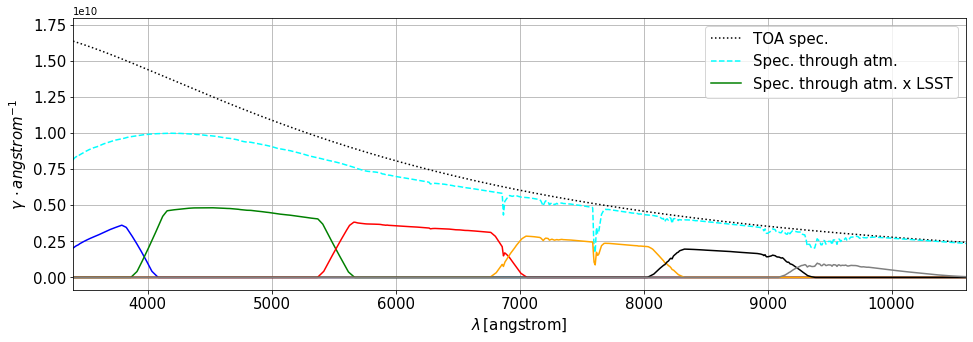

In [101]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

ax.plot(bb0_std.wave,bb0_std.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
ax.plot(bb_atm_std.binwave,bb_atm_std.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)

for index,filter in enumerate(filters):
    print(filter)
    obs = bb_total_dict_std[filter]
    #for obs in obstotal_dict[filter]:
    ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)

ax.set_xlim(WLMIN,WLMAX)
#ax.set_ylim(0.,0.5e13)
ax.set_xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA spec.')
ax.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
ax.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

In [102]:
Phi_dict_bb_std = {}
Phi_dict_bb_std_err = {}
Phi_dict_bb_min = {}
Phi_dict_bb_max = {}
for filter in filters:
    num_,num_err_ = myPhi(bb0_std,total_passband_ref[filter],return_error=True)
    Phi_dict_bb_std[filter] = num_
    Phi_dict_bb_std_err[filter] = num_err_
    num_ = myPhi(bb0_min,total_passband[filter][min_ind_],return_error=False)
    Phi_dict_bb_min[filter] = num_
    num_ = myPhi(bb0_max,total_passband[filter][max_ind_],return_error=False)
    Phi_dict_bb_max[filter] = num_
    #print(num_err_)
    #print('#############')
    

ATTENTION: converting flux units to fnu
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Variance of the numerator = 3.34e+11
ATTENTION: converting flux units to fnu
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
ATTENTION: converting flux units to fnu
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
ATTENTION: converting flux units to fnu
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Variance of the numerator = 2.50e+12
ATTENTION: converting flux units to fnu
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
ATTENTION: converting flux units to fnu
((g * Atm. transp. 9)) does not have a defined binset in

### Comparison plots with respect to standard (reference) atmosphere 

We compare the integrated flux obtained from the **real spectrum** and the **fitted one** 

u
g
r
i
z
Y
photlam


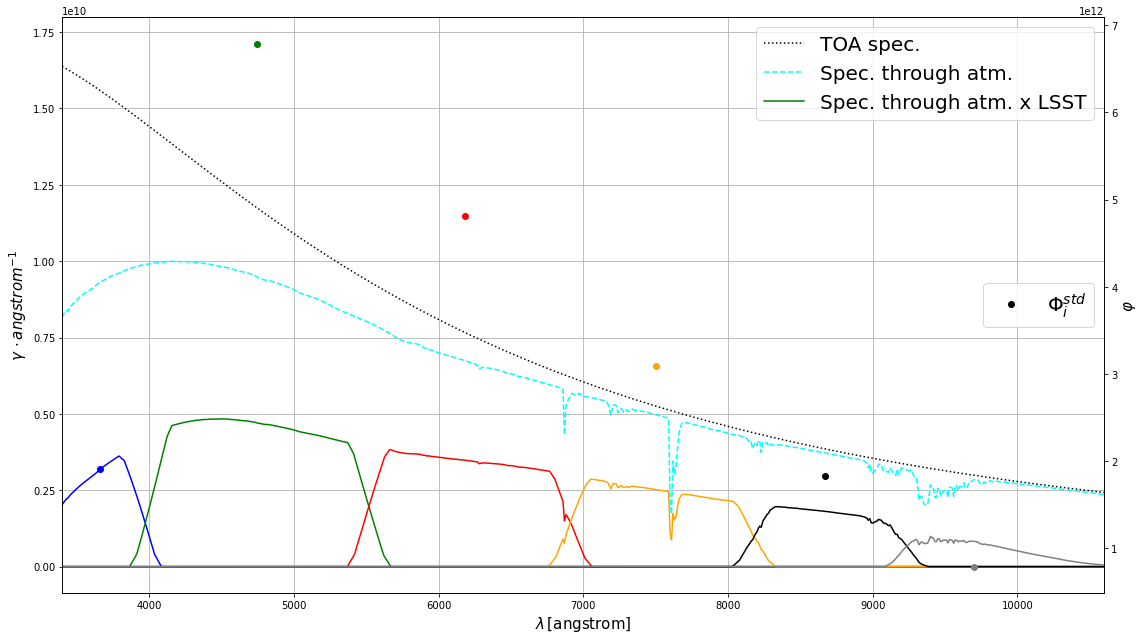

In [103]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(bb0_std.wave,bb0_std.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
#ax1.plot(flatsp.wave,flatsp.flux*Seff*exptime,ls='--',color='k',label='TOA AB spec.')

ax1.plot(bb_atm_std.binwave,bb_atm_std.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)
ax2 = ax1.twinx()

eff_lambda_poly = {}
for index,filter in enumerate(filters):
    print(filter)
    obs = bb_total_dict_std[filter]
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
    
    #obs_ref_ = obstotal = S.Observation(example_spec,total_passband_ref[filter],force='taper')
    eff_l_ = obs.efflam()
    eff_lambda_poly[filter] = eff_l_
    
ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_ylim(0.,0.5e13)
ax1.set_xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
ax1.grid()
ax1.plot([],[],ls=':',color='k',label='TOA spec.')
ax1.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
ax1.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda_poly[filter],Phi_dict_bb_std[filter],marker='o',color=filter_colors[index])

ax2.plot([],[],ls='',marker='o',color='k',label=r'$\Phi^{std}_i$')
ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20,loc="center right")
plt.tight_layout()
print(spec.fluxunits)

u
g
r
i
z
Y
photlam


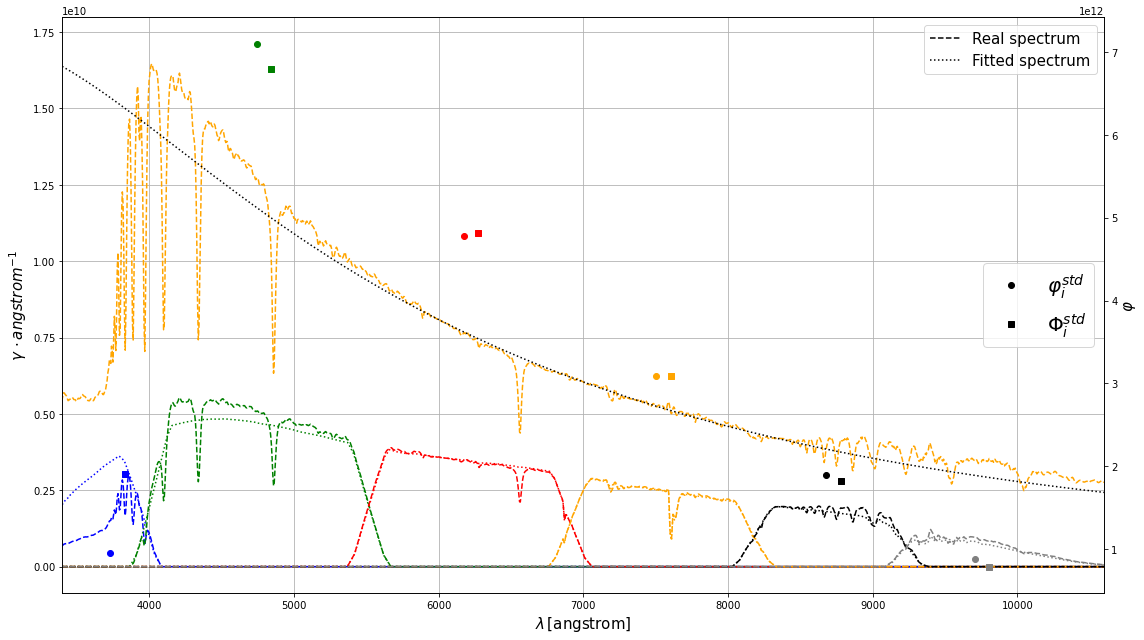

In [104]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls='--',color='orange',alpha=1.0)
ax1.plot(bb0_std.wave,bb0_std.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
#ax1.plot(flatsp.wave,flatsp.flux*Seff*exptime,ls='--',color='k',label='TOA AB spec.')

#ax1.plot(bb_atm.binwave,bb_atm.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)
ax2 = ax1.twinx()

eff_lambda_poly = {}
for index,filter in enumerate(filters):
    print(filter)
    obs = obstotal_dict_ref[filter]
    obs_poly = bb_total_dict_std[filter]
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='--',color=filter_colors[index],alpha=1.0)
    ax1.plot(obs_poly.binwave,obs_poly.binflux*Seff*exptime,ls=':',color=filter_colors[index],alpha=1.0)
    
    #obs_ref_ = obstotal = S.Observation(example_spec,total_passband_ref[filter],force='taper')
    eff_l_ = obs.efflam()
    eff_lambda_poly[filter] = eff_l_
    
ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_ylim(0.,0.5e13)
ax1.plot([],[],ls='--',color='k',label='Real spectrum')
ax1.plot([],[],ls=':',color='k',label='Fitted spectrum')
ax1.set_xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
ax1.grid()

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda[filter],phi_dict_std[filter],marker='o',color=filter_colors[index])
    ax2.scatter(eff_lambda_poly[filter]+100.,Phi_dict_bb_std[filter],marker='s',color=filter_colors[index])

ax2.plot([],[],ls='',marker='o',color='k',label=r'$\varphi^{std}_i$')
ax2.plot([],[],ls='',marker='s',color='k',label=r'$\Phi^{std}_i$')
ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=15)
ax2.legend(fontsize=20,loc='center right')
plt.tight_layout()
print(spec.fluxunits)

### Now we show the integrated fluxes from the fitted spectrum for the minimum, maximum and standard passbands 

u
g
r
i
z
Y
photlam


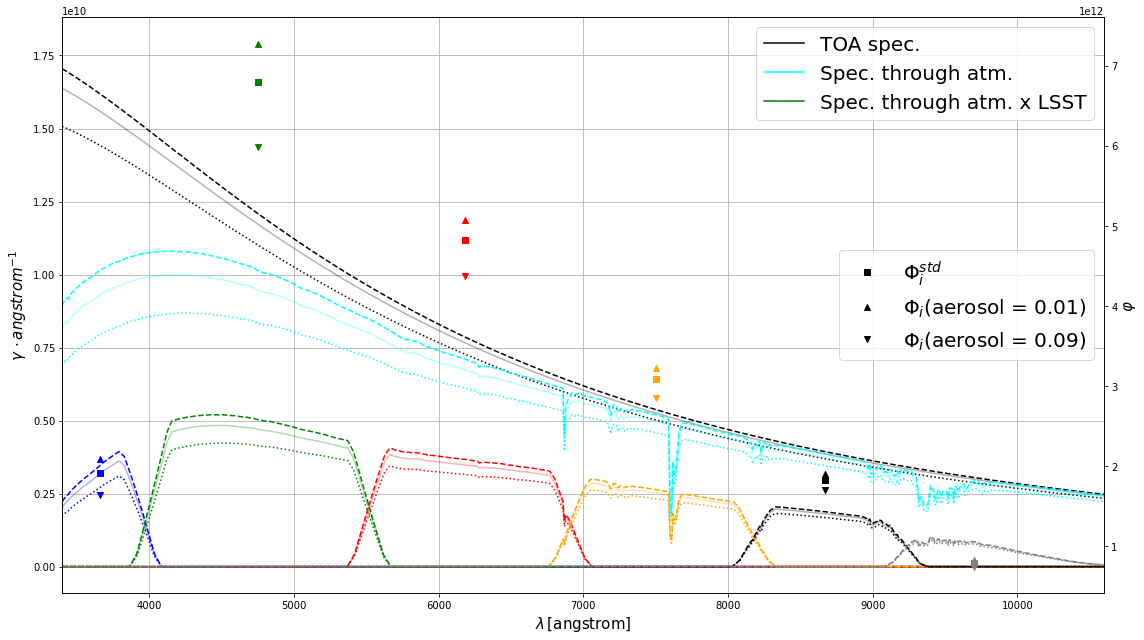

In [105]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(bb0_std.wave,bb0_std.flux*Seff*exptime,ls='-',color='k',alpha=0.3)
ax1.plot(bb0_std.wave,bb0_min.flux*Seff*exptime,ls='--',color='k',alpha=1.0)
ax1.plot(bb0_std.wave,bb0_max.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
#ax1.plot(flatsp.wave,flatsp.flux*Seff*exptime,ls='--',color='k',label='TOA AB spec.')

ax1.plot(bb_atm_std.binwave,bb_atm_std.binflux*Seff*exptime,ls='-',color='cyan',alpha=0.3)
ax1.plot(bb_atm_std.binwave,bb_atm_min.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)
ax1.plot(bb_atm_std.binwave,bb_atm_max.binflux*Seff*exptime,ls=':',color='cyan',alpha=1.0)
ax2 = ax1.twinx()

eff_lambda_poly = {}
for index,filter in enumerate(filters):
    print(filter)
    obs = bb_total_dict_std[filter]
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.3)
    obs = bb_total_dict_min[filter]
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='--',color=filter_colors[index],alpha=1.0)
    obs = bb_total_dict_max[filter]
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls=':',color=filter_colors[index],alpha=1.0)
    
    #obs_ref_ = obstotal = S.Observation(example_spec,total_passband_ref[filter],force='taper')
    eff_l_ = obs.efflam()
    eff_lambda_poly[filter] = eff_l_
    
ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_ylim(0.,0.5e13)
ax1.set_xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
ax1.grid()
ax1.plot([],[],ls='-',color='k',label='TOA spec.')
ax1.plot([],[],ls='-',color='cyan',label='Spec. through atm.')
ax1.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda_poly[filter],Phi_dict_bb_std[filter],marker='s',color=filter_colors[index])
    ax2.scatter(eff_lambda_poly[filter],Phi_dict_bb_min[filter],marker='^',color=filter_colors[index])
    ax2.scatter(eff_lambda_poly[filter],Phi_dict_bb_max[filter],marker='v',color=filter_colors[index])

ax2.plot([],[],ls='',marker='s',color='k',label=r'$\Phi^{std}_i$')
ax2.plot([],[],ls='',marker='^',color='k',label=r'$\Phi_i($'+'{0} = {1})'.format(variable_param,min_val_))
ax2.plot([],[],ls='',marker='v',color='k',label=r'$\Phi_i($'+'{0} = {1})'.format(variable_param,max_val_))
ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20,loc="center right")
plt.tight_layout()
print(spec.fluxunits)

### And now we compare with the integrated fluxes from the real spectrum 

u
g
r
i
z
Y
photlam


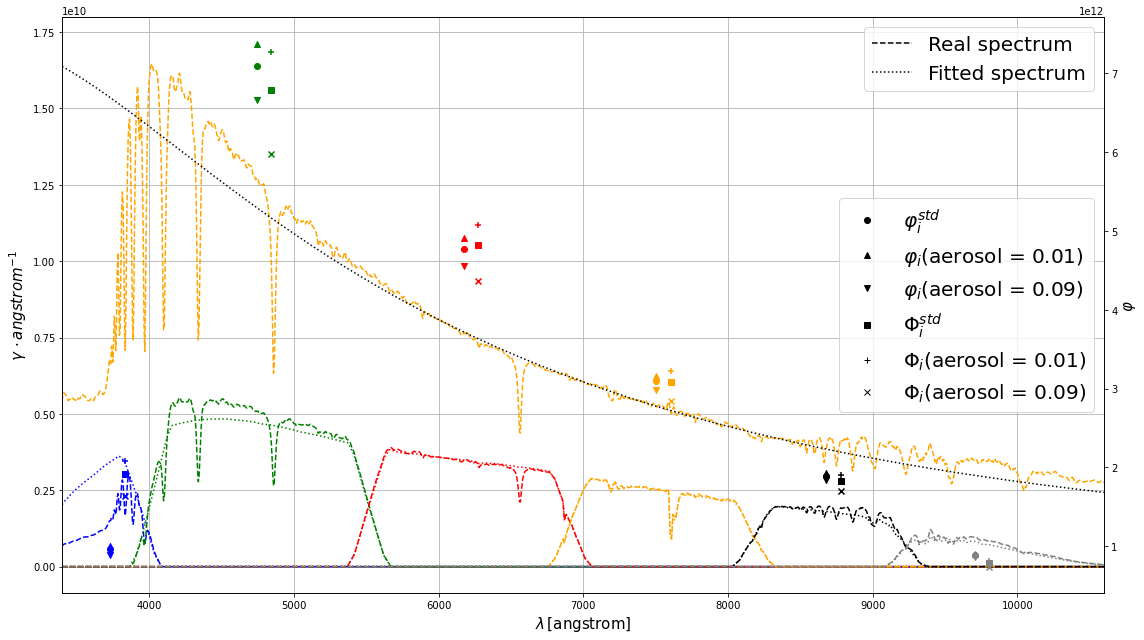

In [106]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls='--',color='orange',alpha=1.0)
ax1.plot(bb0_std.wave,bb0_std.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
#ax1.plot(flatsp.wave,flatsp.flux*Seff*exptime,ls='--',color='k',label='TOA AB spec.')

#ax1.plot(bb_atm.binwave,bb_atm.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)
ax2 = ax1.twinx()

eff_lambda_poly = {}
for index,filter in enumerate(filters):
    print(filter)
    obs = obstotal_dict_ref[filter]
    obs_poly = bb_total_dict_std[filter]
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='--',color=filter_colors[index],alpha=1.0)
    ax1.plot(obs_poly.binwave,obs_poly.binflux*Seff*exptime,ls=':',color=filter_colors[index],alpha=1.0)
    
    #obs_ref_ = obstotal = S.Observation(example_spec,total_passband_ref[filter],force='taper')
    eff_l_ = obs.efflam()
    eff_lambda_poly[filter] = eff_l_
    
ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_ylim(0.,0.5e13)
ax1.plot([],[],ls='--',color='k',label='Real spectrum')
ax1.plot([],[],ls=':',color='k',label='Fitted spectrum')
ax1.set_xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
ax1.grid()

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda[filter],phi_dict_std[filter],marker='o',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter],phi_dict_min[filter],marker='^',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter],phi_dict_max[filter],marker='v',color=filter_colors[index])
    ax2.scatter(eff_lambda_poly[filter]+100.,Phi_dict_bb_std[filter],marker='s',color=filter_colors[index])
    ax2.scatter(eff_lambda_poly[filter]+100.,Phi_dict_bb_min[filter],marker='+',color=filter_colors[index])
    ax2.scatter(eff_lambda_poly[filter]+100.,Phi_dict_bb_max[filter],marker='x',color=filter_colors[index])

ax2.plot([],[],ls='',marker='o',color='k',label=r'$\varphi^{std}_i$')
ax2.plot([],[],ls='',marker='^',color='k',label=r'$\varphi_i($'+'{0} = {1})'.format(variable_param,min_val_))
ax2.plot([],[],ls='',marker='v',color='k',label=r'$\varphi_i($'+'{0} = {1})'.format(variable_param,max_val_))
ax2.plot([],[],ls='',marker='s',color='k',label=r'$\Phi^{std}_i$')
ax2.plot([],[],ls='',marker='+',color='k',label=r'$\Phi_i($'+'{0} = {1})'.format(variable_param,min_val_))
ax2.plot([],[],ls='',marker='x',color='k',label=r'$\Phi_i($'+'{0} = {1})'.format(variable_param,max_val_))
#ax2.set_yscale("log")
ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20,loc='center right')
plt.tight_layout()
print(spec.fluxunits)

# Color compensation 

Let us introduce the notation and formalism: 

$$ m_{i,b}(t) = -2.5 \log_{10} \frac{\int F_i(\lambda) \, T_b(\lambda,t) \, S_{eff} \, t_{exp} \frac{d\lambda}{h\lambda}}{\int F_{AB} \, T_{tel,b}(\lambda) \, S_{eff} \, t_{exp} \frac{d\lambda}{h\lambda}} = -2.5 \log_{10} \frac{\varphi_{i,b}(t)}{\Phi_{AB,b}}$$ 

$$T_b (\lambda,t) = T_{tel,b}(\lambda) \cdot T_{atm}(\lambda,t) $$ 

$$T^{std}_b (\lambda) = T_{tel,b}(\lambda) \cdot T^{std}_{atm}(\lambda) $$ 

$$\vec{\varphi}^{\, corr}_i = \vec{\varphi}_i(t) \cdot \frac{\vec{\Phi}^{std}_i}{\vec{\Phi}_i(t)} $$

$$\Phi^{std}_{i,b} = \int \hat{F}_i(\lambda) \, T^{std}_b(\lambda) \, S_{eff} \, t_{exp} \, \frac{d\lambda}{h \lambda} $$

$$\Phi_{i,b}(t) = \int \hat{F}_i(\lambda) \, T_b(\lambda,t) \, S_{eff} \, t_{exp} \, \frac{d\lambda}{h \lambda} $$ 

$$\vec{\varphi}^{\, corr}_{i,\mu+1} = \vec{\varphi}_{i,\mu}(t) \cdot \frac{\vec{\Phi}^{std}_i}{\vec{\Phi}_i(t)} $$ 


In [107]:
phi_min,phi_max

(array([1.00624455e+12, 7.37871475e+12, 4.90547704e+12, 3.15980877e+12,
        1.92540221e+12, 8.94917932e+11]),
 array([8.85250931e+11, 6.65995240e+12, 4.56023243e+12, 2.98579967e+12,
        1.83693715e+12, 8.60953636e+11]))

In [108]:
Phi_t_min = []
Phi_t_max = []
Phi_std = []
for filter in filters:
    Phi_t_min.append(Phi_dict_bb_min[filter])
    Phi_t_max.append(Phi_dict_bb_max[filter])
    Phi_std.append(Phi_dict_bb_std[filter])
Phi_t_min = np.array(Phi_t_min)
Phi_t_max = np.array(Phi_t_max)
Phi_std = np.array(Phi_std)

We compare the result of doing 

$$ \vec{\varphi}^{\, corr}_i = \vec{\varphi}_i(t) \cdot \frac{\vec{\Phi}^{std}_i}{\vec{\Phi}_i(t)}  $$

with the *real* result the real spectrum passing through the *standard atmosphere*, that is, $\vec{\varphi}^{std}_i $ 

In [109]:
test_atm = 'max'

In [110]:
phi_test = eval('phi_{0}'.format(test_atm))
Phi_test = eval('Phi_t_{0}'.format(test_atm))

In [111]:
phi_corr = phi_test*Phi_std/Phi_test

In [112]:
phi_std,phi_corr

(array([9.58768416e+11, 7.10000039e+12, 4.77402649e+12, 3.09451537e+12,
        1.89259802e+12, 8.82497944e+11]),
 array([1.03756098e+12, 7.56420648e+12, 5.03038040e+12, 3.24161026e+12,
        1.97561979e+12, 9.19029008e+11]))

In [113]:
print(phi_corr/phi_std)

[1.08218101 1.06538114 1.05369763 1.04753406 1.04386656 1.04139507]


In [114]:
print(phi_test)

[8.85250931e+11 6.65995240e+12 4.56023243e+12 2.98579967e+12
 1.83693715e+12 8.60953636e+11]


In [115]:
print(Phi_std/Phi_test)

[1.17205296 1.13577486 1.10309737 1.08567574 1.07549667 1.0674547 ]


In [116]:
phi_min/Phi_t_min

array([0.48237609, 1.01408174, 0.96650717, 0.97957174, 1.0136895 ,
       1.0961778 ])

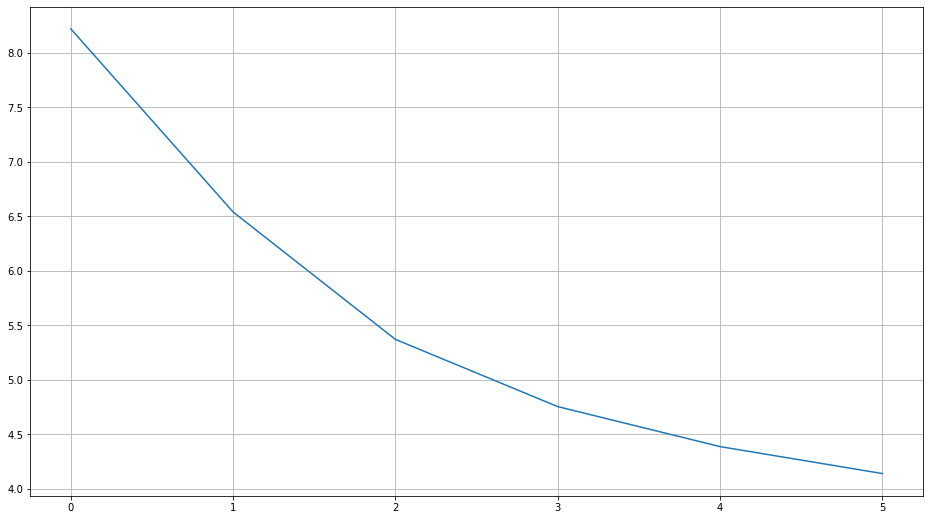

In [117]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.plot(np.arange(len(phi_corr)),(phi_corr-phi_std)*100./phi_std)
ax.grid()

### We now work with magnitudes 

If we express the correction in magnitudes, we have 

$$\vec{m}^{\, corr}_i = \vec{m}_i(t)+\vec{\mathbb{m}}^{std}_i - \vec{\mathbb{m}}_i(t) $$

In [118]:
eval('mag_dict_{0}'.format(test_atm))

{'u': 1.3566673194776182,
 'g': 0.2284646498257505,
 'r': 0.3265926718132814,
 'i': 0.4579931235183937,
 'z': 0.5617457251798059,
 'Y': 0.7048244897379964}

In [119]:
Mag_dict_bb_std = {}
Mag_dict_bb_std_err = {}
Mag_dict_bb_min = {}
Mag_dict_bb_max = {}
for index,filter in enumerate(filters):
    num_,num_err_ = myAB(bb0_std,total_passband_ref[filter],lsst_bp[index],return_error=True)
    Mag_dict_bb_std[filter] = num_
    Mag_dict_bb_std_err[filter] = num_err_
    num_ = myAB(bb0_min,total_passband[filter][min_ind_],lsst_bp[index],return_error=False)
    Mag_dict_bb_min[filter] = num_
    num_ = myAB(bb0_max,total_passband[filter][max_ind_],lsst_bp[index],return_error=False)
    Mag_dict_bb_max[filter] = num_
    #print(num_err_)
    #print('#############')
    

ATTENTION: converting flux units to fnu
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Observation units =  fnu
n_i =  [1.71237346e+10 1.71228820e+10 1.71220231e+10 ... 1.99872068e+09
 1.99829828e+09 1.99787600e+09]
Numerator = 1.91e+12
Variance of the numerator = 3.34e+11
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
AB observation units =  fnu
Denominator = 3.09e+12
AB magnitude =  0.5201789088132098
---------
ATTENTION: converting flux units to fnu
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
Observation units =  fnu
Numerator = 2.09e+12
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
AB observation units =  fnu
Denominator = 3.09e+12
AB magnitude =  0.4260385559530129
---------
ATTENTION: converting flux un

In [120]:
m_std = []
m_t_min = []
m_t_max = []
M_std = []
M_t_min = []
M_t_max = []
for filter in filters:
    m_std.append(mag_dict_std[filter])
    m_t_min.append(mag_dict_min[filter])
    m_t_max.append(mag_dict_max[filter])
    M_t_min.append(Mag_dict_bb_min[filter])
    M_t_max.append(Mag_dict_bb_max[filter])
    M_std.append(Mag_dict_bb_std[filter])
m_std = np.array(m_std)
m_t_min = np.array(m_t_min)
m_t_max = np.array(m_t_max)
M_t_min = np.array(M_t_min)
M_t_max = np.array(M_t_max)
M_std = np.array(M_std)

In [121]:
m_test = eval('m_t_{0}'.format(test_atm))
M_test = eval('M_t_{0}'.format(test_atm))

In [122]:
m_corr = m_test+M_std-M_test
print(m_corr)
print(m_std)

[1.18429923 0.09023402 0.22005805 0.36874279 0.48272305 0.63395085]
[1.270049   0.15899653 0.27684806 0.41916318 0.52933551 0.67798964]


In [123]:
(m_corr-m_std)*1000. #mmag 

array([-85.7497745 , -68.76250802, -56.7900097 , -50.42038297,
       -46.61246312, -44.03879233])